In [1]:
#Goal of this notebook is to incorporate pymc3 modeling with a large dataset and predict pace.

In [2]:
#pip install pymc3

In [3]:
#pip install arviz==0.10.0 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy.integrate import odeint
size = (12, 9)

import json
import datetime as dt

import theano
import theano.tensor as tt
import statsmodels.api as sm
import pymc3 as pm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

In [2]:
import arviz as az

In [3]:
pm.__version__

'3.11.1'

In [4]:
az.__version__

'0.11.2'

In [5]:
#Should be running pymc3 3.7 and arviz 0.10 to avoid errors later

In [6]:
raw_df = pd.read_csv('./data/clean/garmin_clean/clean_3.csv', index_col='date').drop('date.1', axis=1)

In [7]:
raw_df.head(2)

activity_type  favorite           title distance  \
date                                                                     
2021-02-05 16:28:04         Running     False  Denver Running     8.27   
2021-02-05 10:05:44  Indoor Cycling     False  Indoor Cycling     0.00   

                    calories      time  avg_hr  max_hr  aerobic_te  \
date                                                                 
2021-02-05 16:28:04      945  01:02:23     151     170         3.5   
2021-02-05 10:05:44      506  00:40:04     123     137         2.3   

                     avg_run_cadence  ...  decompression best_lap_time  \
date                                  ...                                
2021-02-05 16:28:04              178  ...             No   01:02:22.97   
2021-02-05 10:05:44                0  ...             No      10:01.29   

                    number_of_laps max_temp avg_resp  min_resp  max_resp  \
date                                                                       
2021-02-05 16:28:04              1      0.0       26        14        43   
2021-02-05 10:05:44              3      0.0       28        13        36   

                     athlete_id  filetype is_race  
date                                               
2021-02-05 16:28:04           3    garmin       0  
2021-02-05 10:05:44           3    garmin       0  

[2 rows x 49 columns]

In [8]:
len(raw_df)

2340

In [9]:
running = raw_df[raw_df['activity_type'] == 'Running']

In [10]:
len(running)

668

In [11]:
running['distance'] = pd.to_numeric(running['distance'])

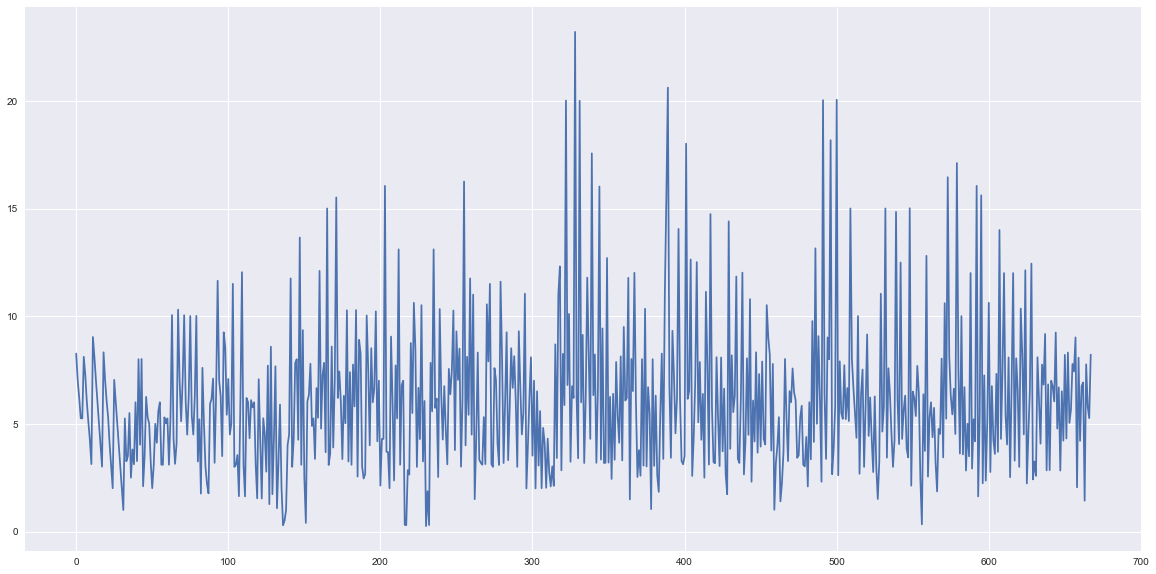

In [12]:
plt.figure(figsize = (20,10))
plt.plot(range(668), running['distance']);

In [13]:
#Read in the athlete dictionary:
with open("./data/athletes.json") as json_file: 
    athletes = json.load(json_file)

In [14]:
def analyze_file(filepath, sport, athlete_id): #Athlete id is a number no need to pass it the string:
    '''
    This function takes in a file, converts all the columns to numeric and date that we need,
    creates a speed column for running that converts pace to speed in ft/s, and prepares the 
    columns for the fit function that will later be used to predict the running pace. It will 
    create and output all the graphs we have here, for each of the races in the filepath.
    '''
    #Read in the dataframe:
    raw = pd.read_csv(filepath)
    sport = sport
    athlete_max_hr = athletes[str(athlete_id)]['max_hr']
    #Filter down just to the sport:
    df = raw[raw['activity_type'] == sport]
    
    
    #Setting average pace to a timedelta, we use a try in case the data does not have avg_pace column:
    try:
        df['avg_pace'] = pd.to_timedelta(df['avg_pace'])
    except:
        print("No avg_pace column!")
    
    try:
        df['distance'] = pd.to_numeric(df['distance'])
    except:
        print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    try:
        df['elev_gain'] = pd.to_numeric(df['elev_gain'].str.replace(',', ''))
    except:
        try:
            df['elev_gain'] = pd.to_numeric(df['elev_gain'])
        except:
            print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    #Create ft/mile column and intensity for analysis:
    df['ft_per_mile'] = (df['elev_gain']/df['distance'])
    df['intensity'] = df['avg_hr']/athlete_max_hr
    
    
    
    #Do the same for calculating speed in ft/s
    df['spd_ft_s'] = 0.0
    df['spd_mph'] = 0.0
    df.reset_index(inplace=True)
    
    for i in range(len(df['avg_pace'])):
        #.total_seconds returns the total seconds in a timedelta object.
        df['spd_mph'][i] = float(60/(df['avg_pace'][i].total_seconds()/60.0))
        #takes the speed in miles per hour and converts down to ft/s
        df['spd_ft_s'][i] = float(60.0/(df['avg_pace'][i].total_seconds()/60.0))*float(5280.0/3600.0)
        
    #The default is to be equal to the speed not taking into account elevation gain.
    df['GAP_ft_s'] = df['spd_ft_s']
    
    #Now we try to make a GAP column:
    for i in range(len(df)):
        #Try to make a GAP column:
        try:
            #using trig to calculate the change to the pace:
            factor = (np.sqrt((df['distance'][i]*5280)**2+df['elev_gain'][i]**2)/(df['distance'][i]*5280))
            df['GAP_ft_s'][i] = factor*df['spd_ft_s'][i]
        except:
            print("No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.")
        
    #Why divide by intensity? This brings average run pace up to the speed that we would expect if the athlete was at their highest average
    #sustainable heartrate for this speed. 
    df['GAP_by_intensity']  = df['GAP_ft_s']/df['intensity']
    
    #This creates a finalized dataframe with all of the columns I need for creating the pace curves.
    df.to_csv(filepath[:-4]+'_'+sport+'_extra_cols.csv')

In [15]:
filepath = './data/clean/garmin_clean/clean_3.csv'

In [16]:
analyze_file(filepath, 'Running', 3)

In [17]:
#Still need to set the date column to datetime, and set the index with it:

In [18]:
running_df = pd.read_csv('./data/clean/garmin_clean/clean_3_Running_extra_cols.csv', index_col='date').drop('date.1', axis=1)

In [19]:
running_df.head(2)

Unnamed: 0  index activity_type  favorite  \
date                                                             
2021-02-05 16:28:04           0      0       Running     False   
2021-02-04 15:38:04           1      2       Running     False   

                              title  distance calories      time  avg_hr  \
date                                                                       
2021-02-05 16:28:04  Denver Running      8.27      945  01:02:23     151   
2021-02-04 15:38:04  Denver Running      7.03      851  00:56:00     144   

                     max_hr  ...  max_resp  athlete_id  filetype is_race  \
date                         ...                                           
2021-02-05 16:28:04     170  ...        43           3    garmin       0   
2021-02-04 15:38:04     164  ...        44           3    garmin       0   

                    ft_per_mile  intensity   spd_ft_s   spd_mph   GAP_ft_s  \
date                                                                         
2021-02-05 16:28:04   29.383313   0.843575  11.655629  7.947020  11.655810   
2021-02-04 15:38:04   49.502134   0.804469  11.046025  7.531381  11.046511   

                     GAP_by_intensity  
date                                   
2021-02-05 16:28:04         13.817152  
2021-02-04 15:38:04         13.731426  

[2 rows x 57 columns]

In [20]:
len(running_df)

668

In [21]:
running_df.index = pd.to_datetime(running_df.index).normalize()

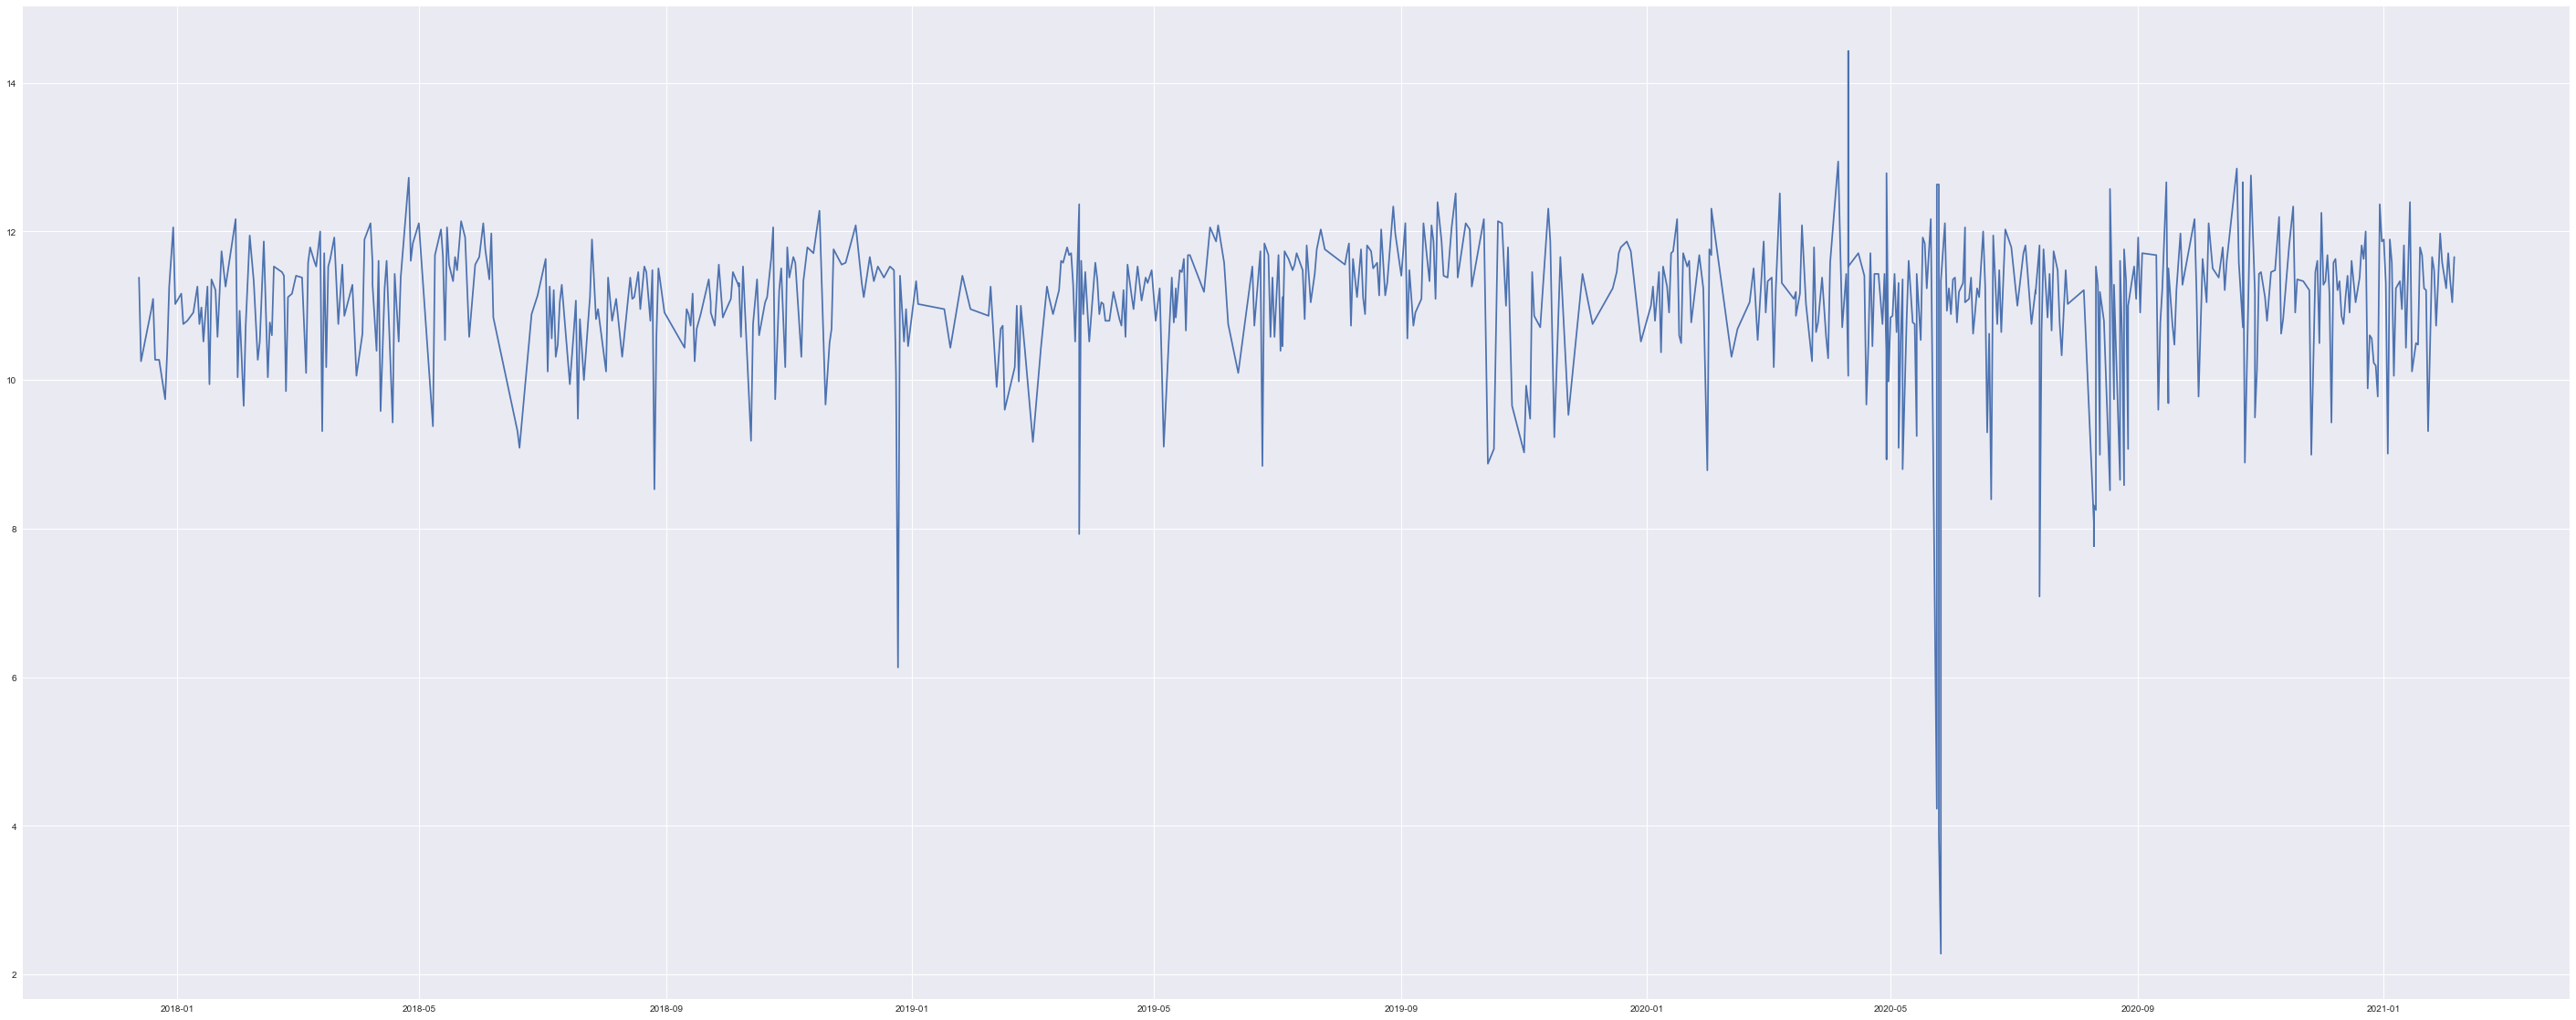

In [22]:
plt.figure(figsize = (50, 20))
plt.plot(running_df['spd_ft_s'])

In [23]:
running_df['spd_ft_s'].describe()

count    668.000000
mean      11.041532
std        0.993297
min        2.279793
25%       10.731707
50%       11.234043
75%       11.604396
max       14.426230
Name: spd_ft_s, dtype: float64

In [24]:
running_df.index.year

Int64Index([2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='date', length=668)

In [25]:
run_2019 = running_df[running_df.index.year == 2019]

Text(0.5, 1.0, 'Run Speed, 2019')

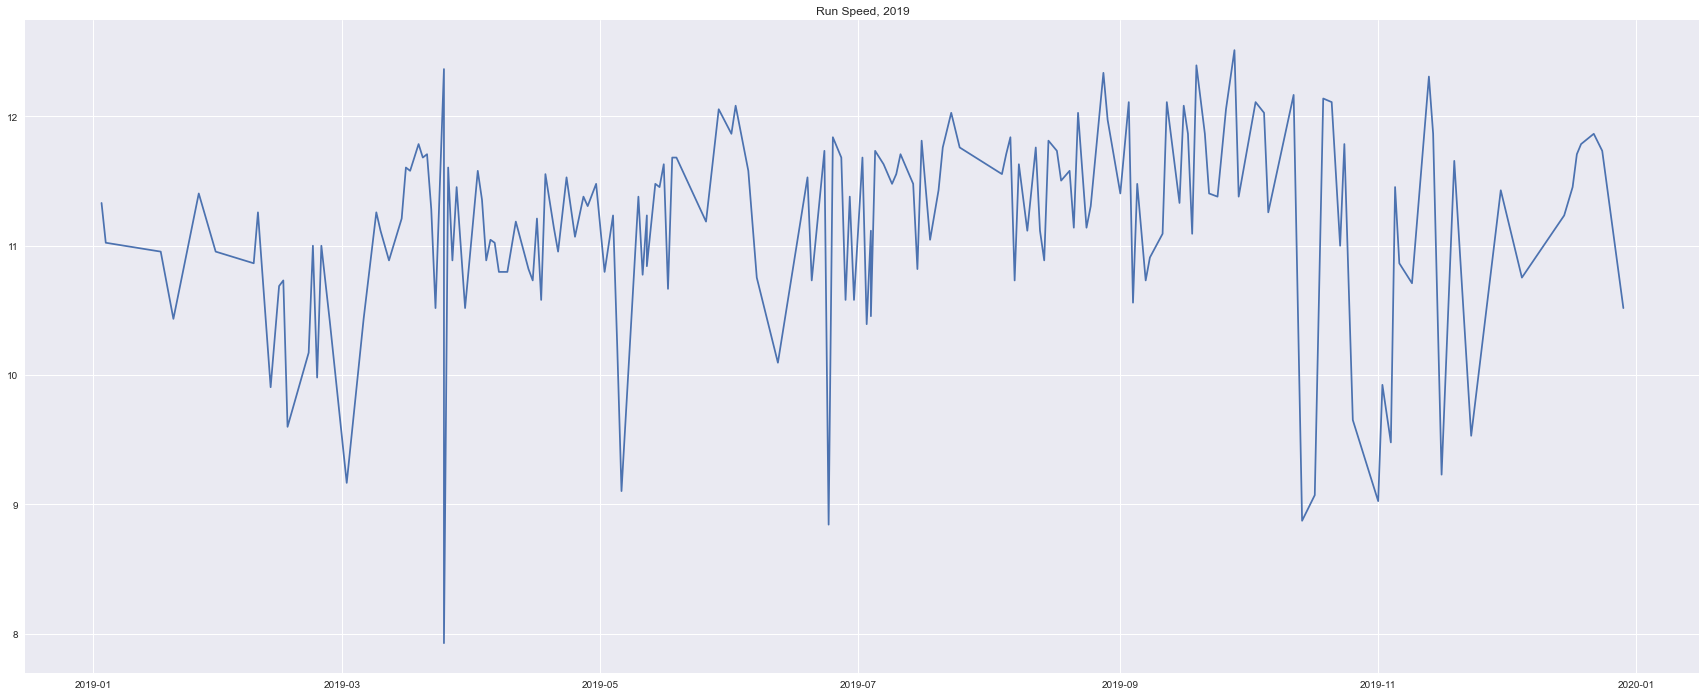

In [26]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['spd_ft_s'])
plt.title('Run Speed, 2019')

Text(0.5, 1.0, 'Run Speed/Intensity, 2019')

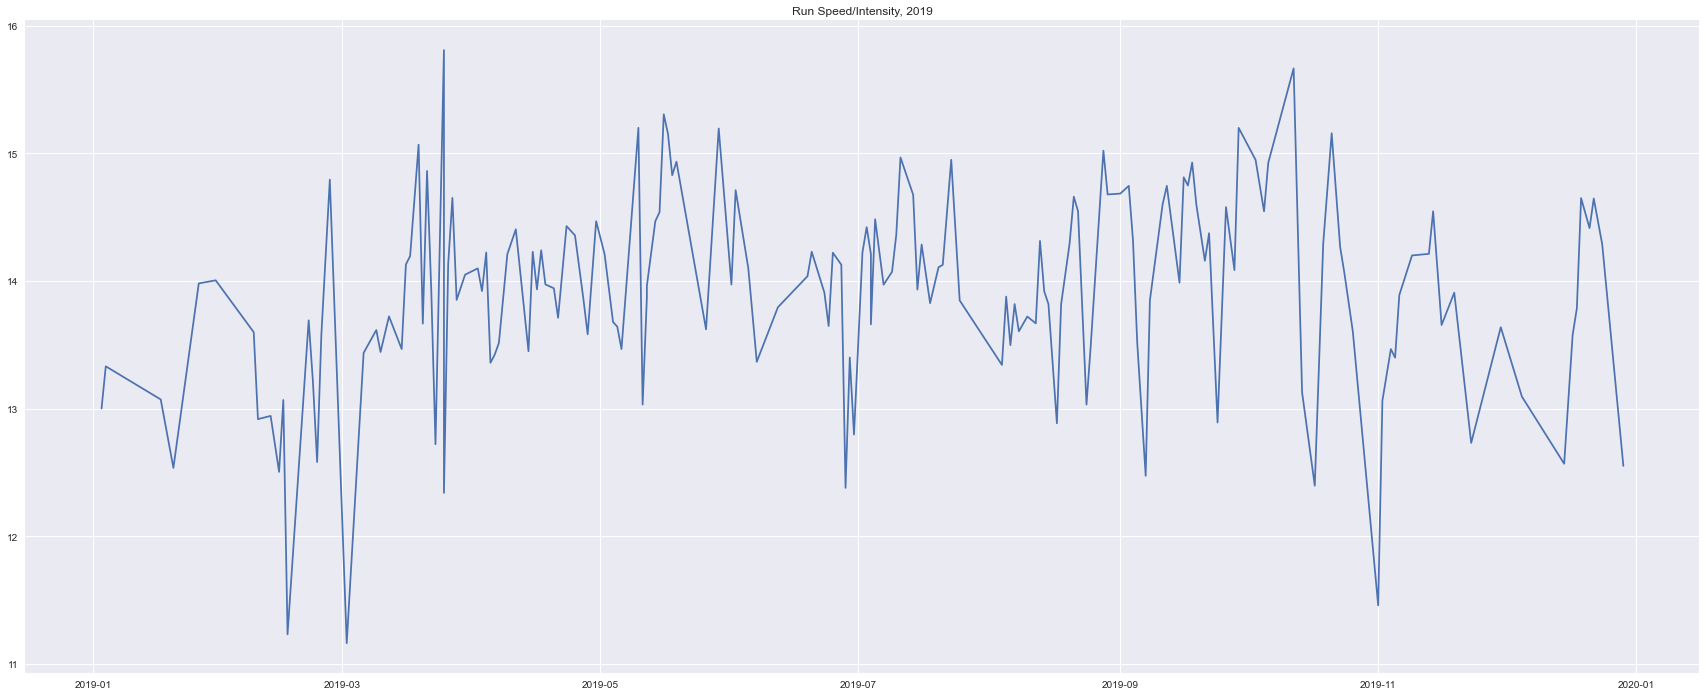

In [27]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['spd_ft_s']/(run_2019['intensity']))
plt.title('Run Speed/Intensity, 2019')

In [28]:
run_2019.columns

Index(['Unnamed: 0', 'index', 'activity_type', 'favorite', 'title', 'distance',
       'calories', 'time', 'avg_hr', 'max_hr', 'aerobic_te', 'avg_run_cadence',
       'max_run_cadence', 'avg_pace', 'best_pace', 'elev_gain', 'elev_loss',
       'avg_stride_length', 'avg_vertical_ratio', 'avg_vertical_oscillation',
       'avg_ground_contact_time', 'avg_gct_balance', 'avg_run_cadence_1',
       'max_run_cadence_1', 'normalized_powerâ_npâ', 'lr_balance',
       'training_stress_scoreâ', 'max_avg_power_20_min', 'avg_power',
       'max_power', 'grit', 'flow', 'total_strokes', 'avg__swolf',
       'avg_stroke_rate', 'total_reps', 'total_sets', 'climb_time',
       'bottom_time', 'min_temp', 'surface_interval', 'decompression',
       'best_lap_time', 'number_of_laps', 'max_temp', 'avg_resp', 'min_resp',
       'max_resp', 'athlete_id', 'filetype', 'is_race', 'ft_per_mile',
       'intensity', 'spd_ft_s', 'spd_mph', 'GAP_ft_s', 'GAP_by_intensity'],
      dtype='object')

Text(0.5, 1.0, 'Run Speed/(Intensity*Distance), 2019')

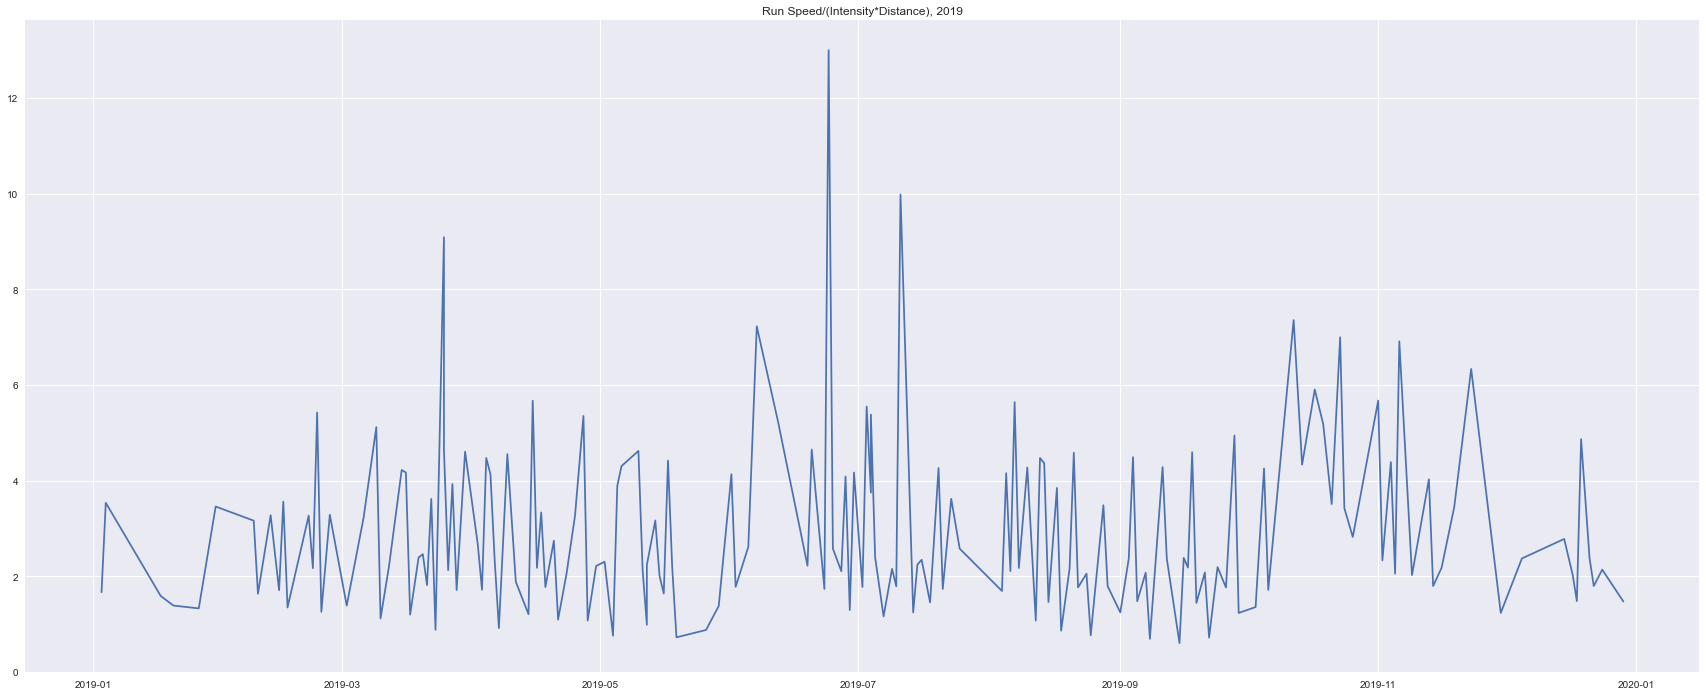

In [29]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['GAP_ft_s']/(run_2019['intensity']*run_2019['distance']))
plt.title('Run Speed/(Intensity*Distance), 2019')

Text(0.5, 1.0, 'Run Speed*Intensity*Distance, 2019')

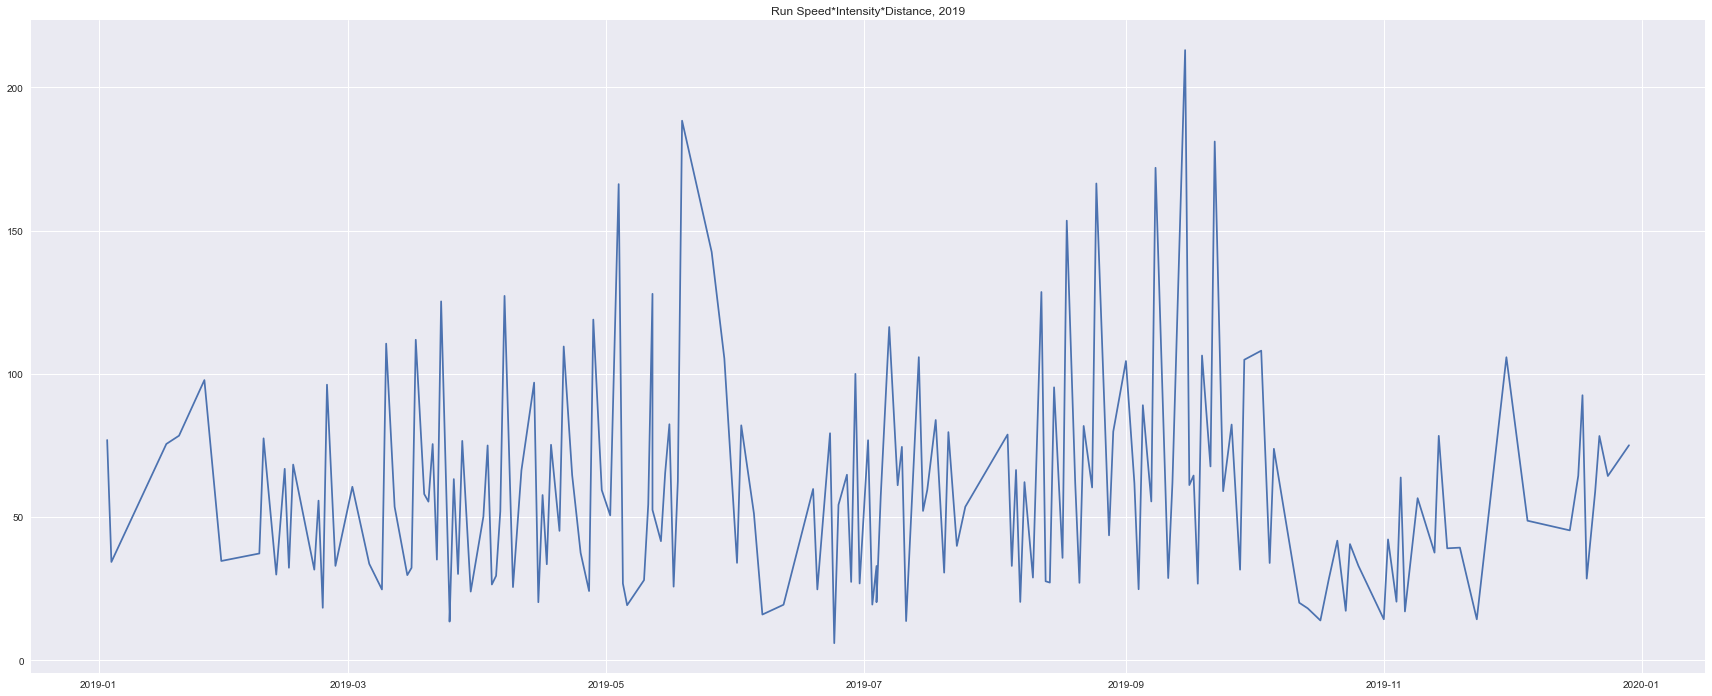

In [30]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['GAP_ft_s']*run_2019['distance']*run_2019['intensity'])
plt.title('Run Speed*Intensity*Distance, 2019')

In [31]:
run_2019['GAP_ft_s'].resample('W').mean()

date
2019-01-06    11.176965
2019-01-13          NaN
2019-01-20    10.695171
2019-01-27    11.403957
2019-02-03    10.955289
2019-02-10    11.061308
2019-02-17    10.232011
2019-02-24    10.538908
2019-03-03     9.790884
2019-03-10    10.936431
2019-03-17    11.320197
2019-03-24    11.394885
2019-03-31    10.792691
2019-04-07    11.114736
2019-04-14    10.934872
2019-04-21    11.028651
2019-04-28    11.320999
2019-05-05    10.930871
2019-05-12    10.667125
2019-05-19    11.432259
2019-05-26    11.186907
2019-06-02    12.000965
2019-06-09    11.166480
2019-06-16    10.095875
2019-06-23    11.331563
2019-06-30    10.817819
2019-07-07    11.168417
2019-07-14    11.554477
2019-07-21    11.373163
2019-07-28    11.893400
2019-08-04    11.553611
2019-08-11    11.404740
2019-08-18    11.468583
2019-08-25    11.438367
2019-09-01    11.904440
2019-09-08    11.158077
2019-09-15    11.511442
2019-09-22    11.784201
2019-09-29    11.831522
2019-10-06    11.798592
2019-10-13    12.166222
2019-10-20 

In [32]:
run_2019['distance'].resample('W').sum()

date
2019-01-06    11.56
2019-01-13     0.00
2019-01-20    17.26
2019-01-27    10.52
2019-02-03     4.05
2019-02-10    12.20
2019-02-17    23.27
2019-02-24    23.40
2019-03-03    12.55
2019-03-10    18.85
2019-03-17    24.64
2019-03-24    38.30
2019-03-31    25.91
2019-04-07    40.29
2019-04-14    21.90
2019-04-21    38.66
2019-04-28    26.65
2019-05-05    34.23
2019-05-12    32.84
2019-05-19    52.00
2019-05-26    15.52
2019-06-02    22.67
2019-06-09     7.24
2019-06-16     2.63
2019-06-23    17.39
2019-06-30    29.72
2019-07-07    35.01
2019-07-14    27.84
2019-07-21    33.26
2019-07-28     9.50
2019-08-04     7.88
2019-08-11    21.66
2019-08-18    47.92
2019-08-25    41.95
2019-09-01    24.29
2019-09-08    44.57
2019-09-15    32.85
2019-09-22    53.16
2019-09-29    29.31
2019-10-06    23.14
2019-10-13     2.13
2019-10-20     7.89
2019-10-27    15.29
2019-11-03     7.62
2019-11-10    18.61
2019-11-17    17.90
2019-11-24     6.04
2019-12-01    11.05
2019-12-08     5.52
2019-12-15     

Text(0.5, 1.0, 'Weekly Run Totals')

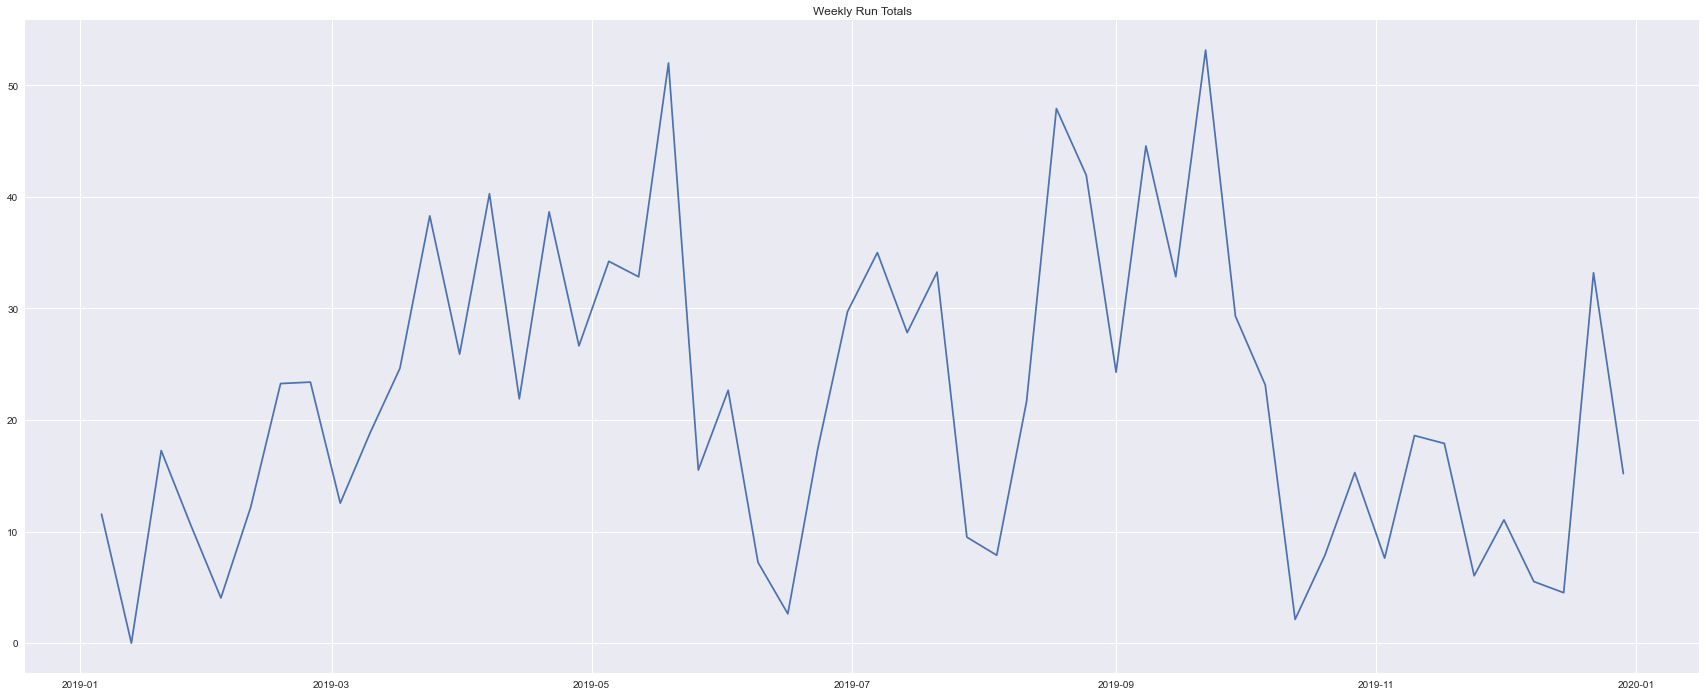

In [33]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['distance'].resample('W').sum())
plt.title('Weekly Run Totals')

Text(0.5, 1.0, 'Monthly Run Totals')

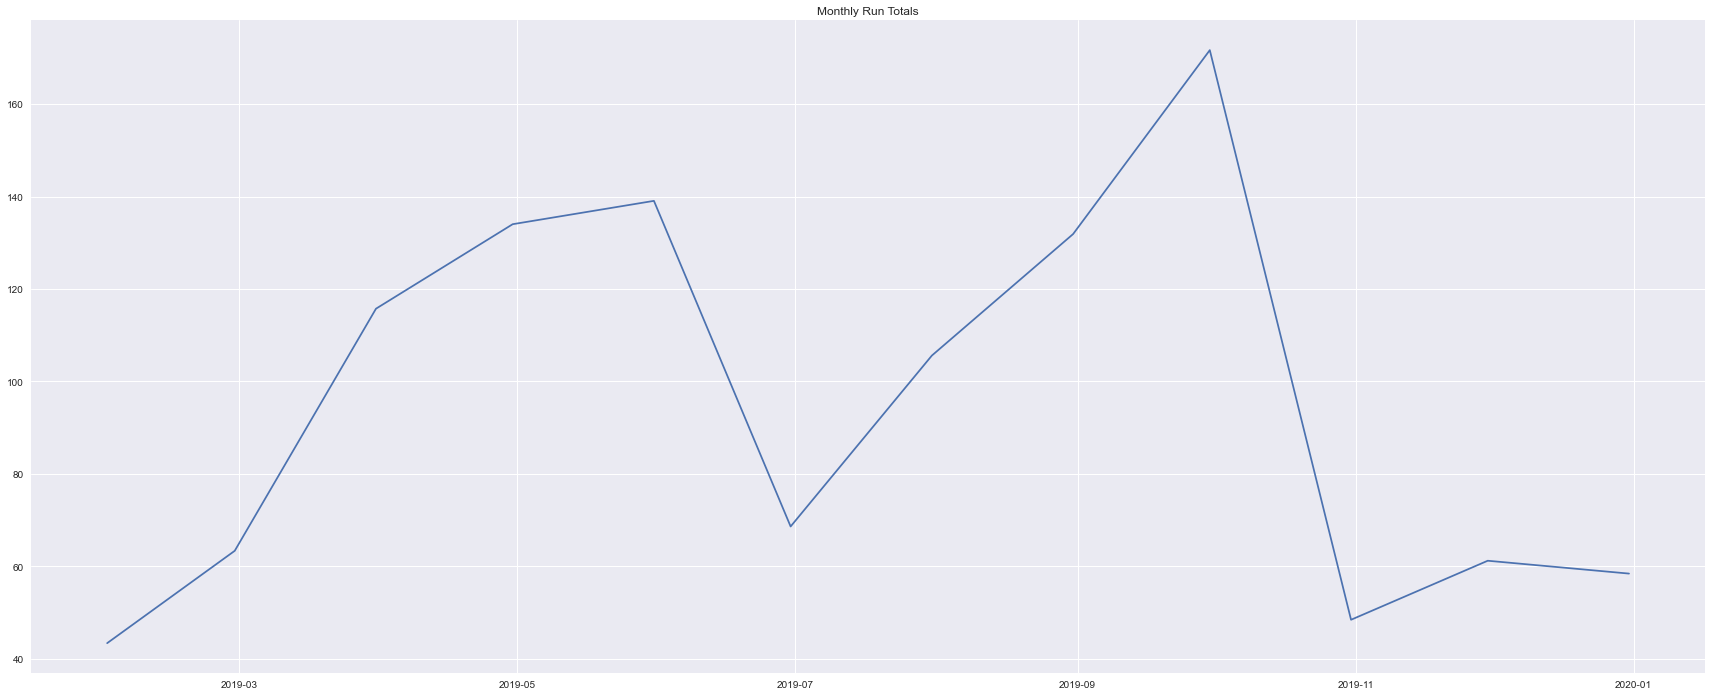

In [34]:
plt.figure(figsize = (30, 12))
plt.plot(run_2019['distance'].resample('M').sum())
plt.title('Monthly Run Totals')

## Lets look at 2018:

In [35]:
run_2018 = running_df[running_df.index.year == 2018]

Text(0.5, 1.0, 'Run Speed, 2018')

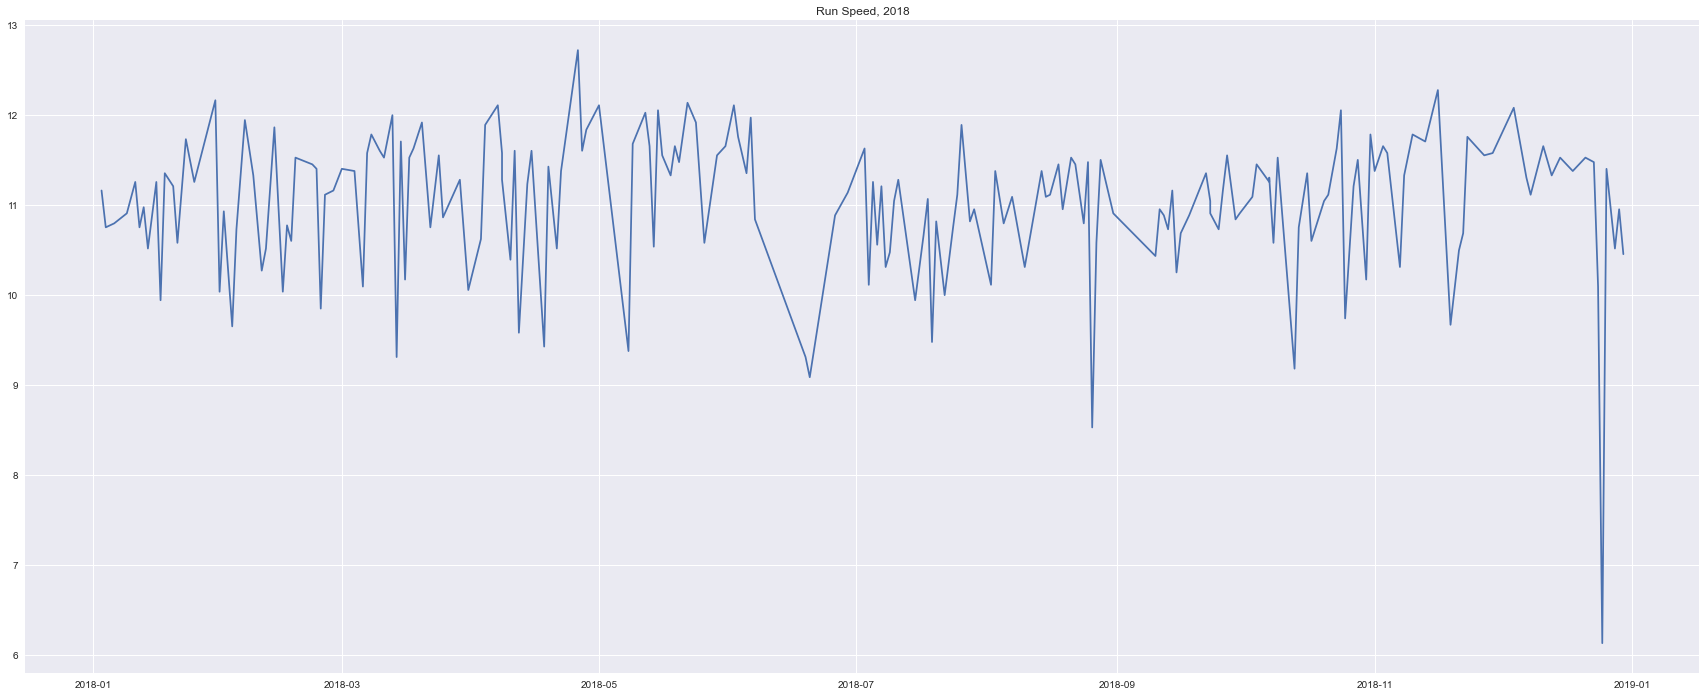

In [36]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['spd_ft_s'])
plt.title('Run Speed, 2018')

Text(0.5, 1.0, 'Run Speed/Intensity, 2018')

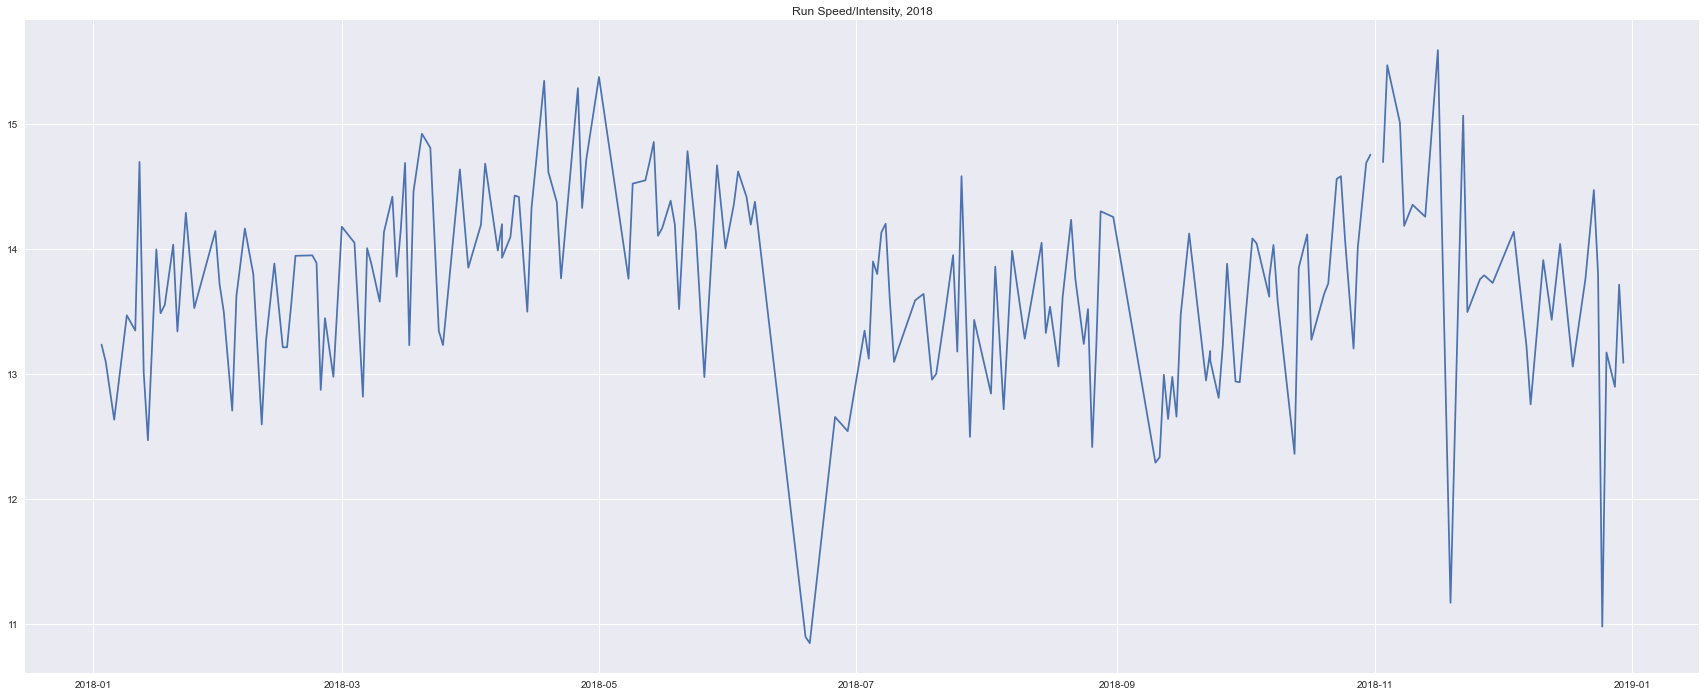

In [37]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['spd_ft_s']/(run_2018['intensity']))
plt.title('Run Speed/Intensity, 2018')

Text(0.5, 1.0, 'Run Speed/(Intensity*Distance), 2018')

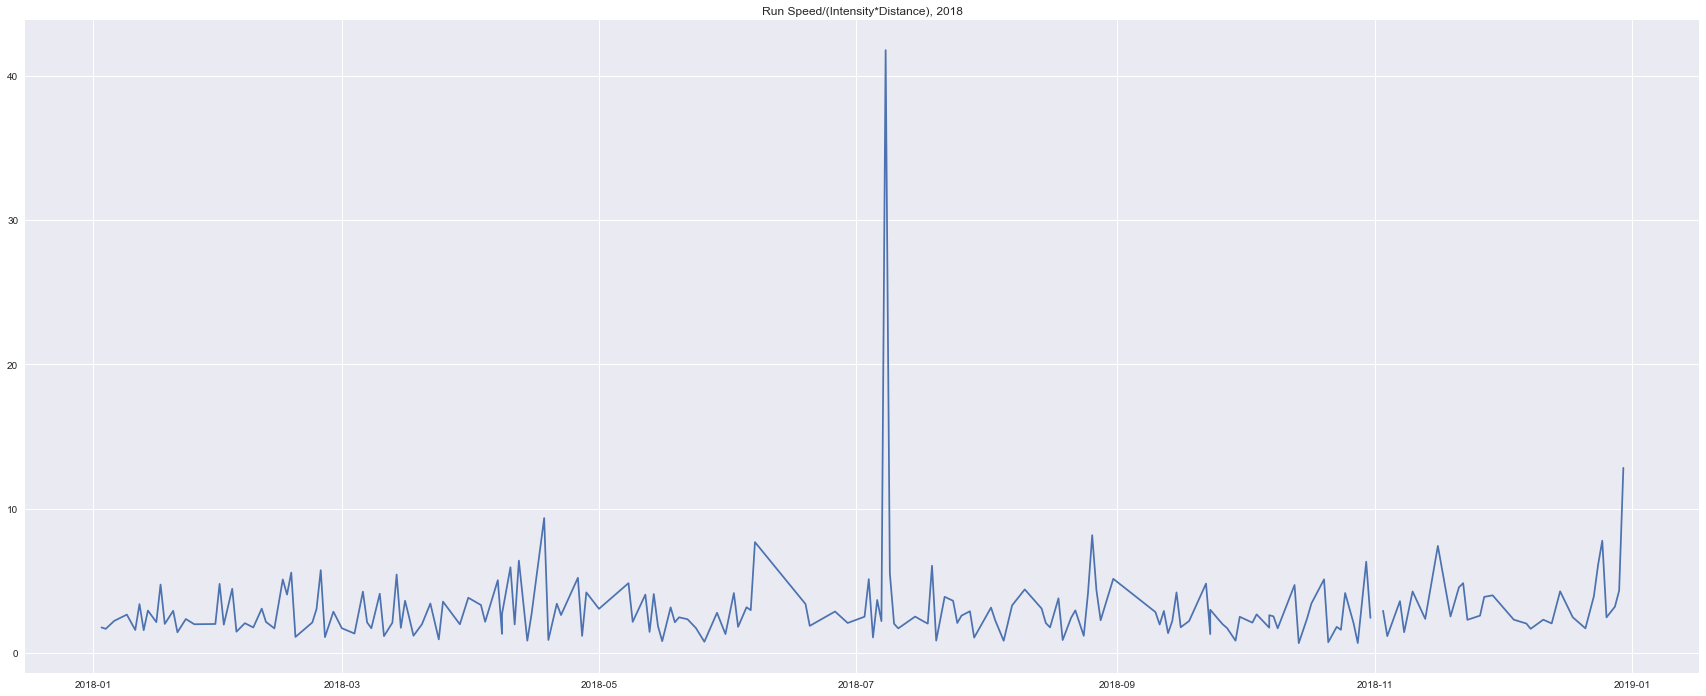

In [38]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['GAP_ft_s']/(run_2018['intensity']*run_2018['distance']))
plt.title('Run Speed/(Intensity*Distance), 2018')

Text(0.5, 1.0, 'Run Speed*Intensity*Distance, 2019')

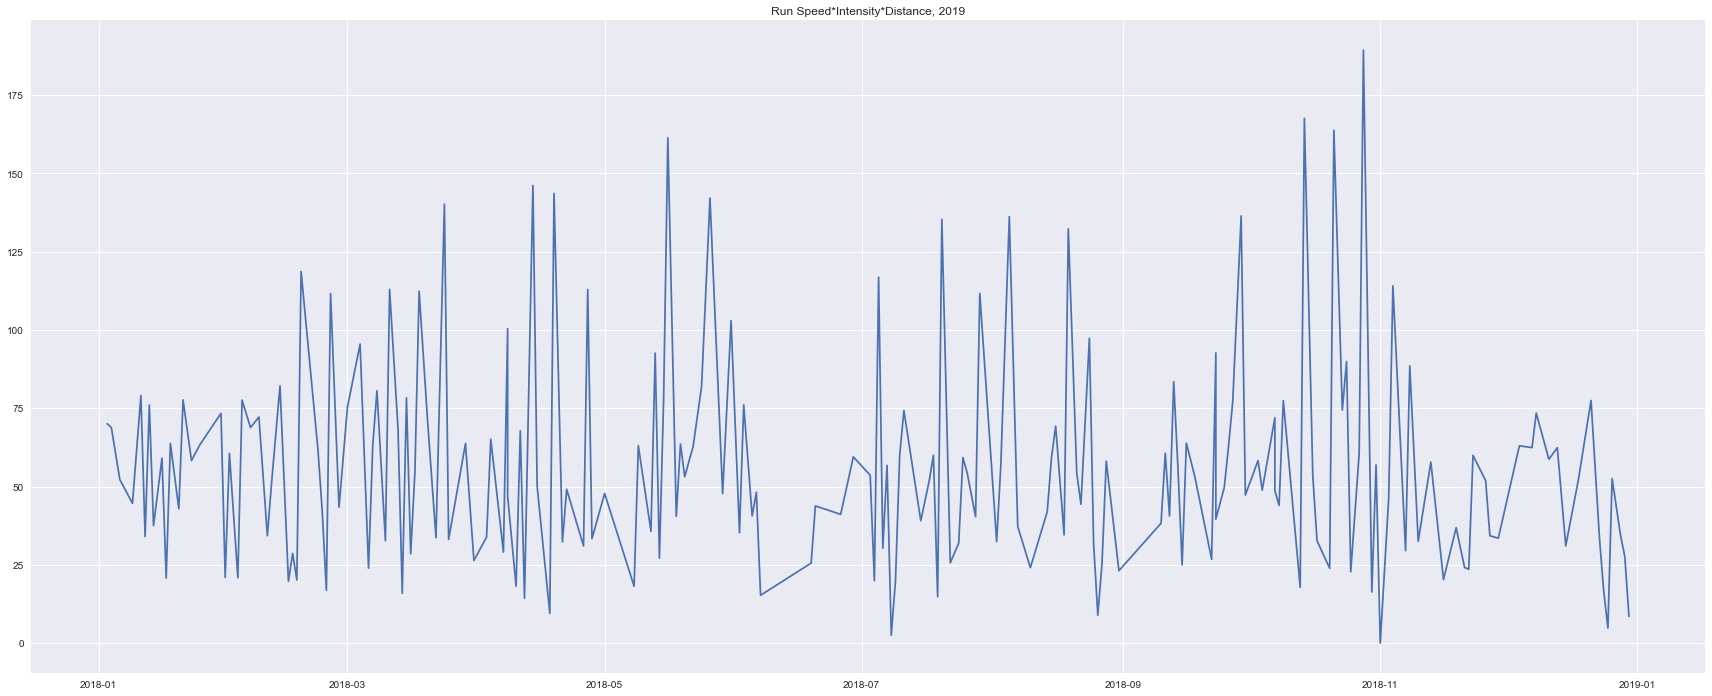

In [39]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['GAP_ft_s']*run_2018['distance']*run_2018['intensity'])
plt.title('Run Speed*Intensity*Distance, 2019')

In [40]:
run_2018['GAP_ft_s'].resample('W').mean()

date
2018-01-07    10.904920
2018-01-14    10.883352
2018-01-21    10.869678
2018-01-28    11.495823
2018-02-04    10.704139
2018-02-11    11.016748
2018-02-18    10.962020
2018-02-25    10.956132
2018-03-04    11.315447
2018-03-11    11.318752
2018-03-18    11.058697
2018-03-25    11.272695
2018-04-01    10.669713
2018-04-08    11.497526
2018-04-15    10.883960
2018-04-22    10.688753
2018-04-29    12.055454
2018-05-06    12.110146
2018-05-13    11.185810
2018-05-20    11.435481
2018-05-27    11.546333
2018-06-03    11.769825
2018-06-10    11.389961
2018-06-17          NaN
2018-06-24     9.204665
2018-07-01    11.013123
2018-07-08    10.847694
2018-07-15    10.687044
2018-07-22    10.407169
2018-07-29    11.107332
2018-08-05    10.764071
2018-08-12    10.702567
2018-08-19    11.199240
2018-08-26    10.757674
2018-09-02    10.997969
2018-09-09          NaN
2018-09-16    10.730557
2018-09-23    11.049287
2018-09-30    11.040032
2018-10-07    11.277607
2018-10-14    10.511972
2018-10-21 

In [41]:
run_2018['distance'].resample('W').sum()

date
2018-01-07    20.89
2018-01-14    30.14
2018-01-21    30.10
2018-01-28    12.81
2018-02-04    28.74
2018-02-11    24.81
2018-02-18    28.83
2018-02-25    25.49
2018-03-04    23.09
2018-03-11    32.96
2018-03-18    38.93
2018-03-25    29.50
2018-04-01    10.94
2018-04-08    29.55
2018-04-15    32.83
2018-04-22    27.12
2018-04-29    18.44
2018-05-06     5.01
2018-05-13    23.15
2018-05-20    44.93
2018-05-27    30.90
2018-06-03    27.35
2018-06-10    11.18
2018-06-17     0.00
2018-06-24     8.96
2018-07-01    10.40
2018-07-08    31.13
2018-07-15    21.97
2018-07-22    33.33
2018-07-29    32.59
2018-08-05    25.03
2018-08-12     7.24
2018-08-19    36.99
2018-08-26    26.29
2018-09-02    12.08
2018-09-09     0.00
2018-09-16    40.53
2018-09-23    23.40
2018-09-30    40.36
2018-10-07    24.87
2018-10-14    36.10
2018-10-21    30.54
2018-10-28    46.82
2018-11-04    35.61
2018-11-11    17.31
2018-11-18     8.11
2018-11-25    16.39
2018-12-02    12.27
2018-12-09    20.14
2018-12-16    1

Text(0.5, 1.0, 'Weekly Run Totals')

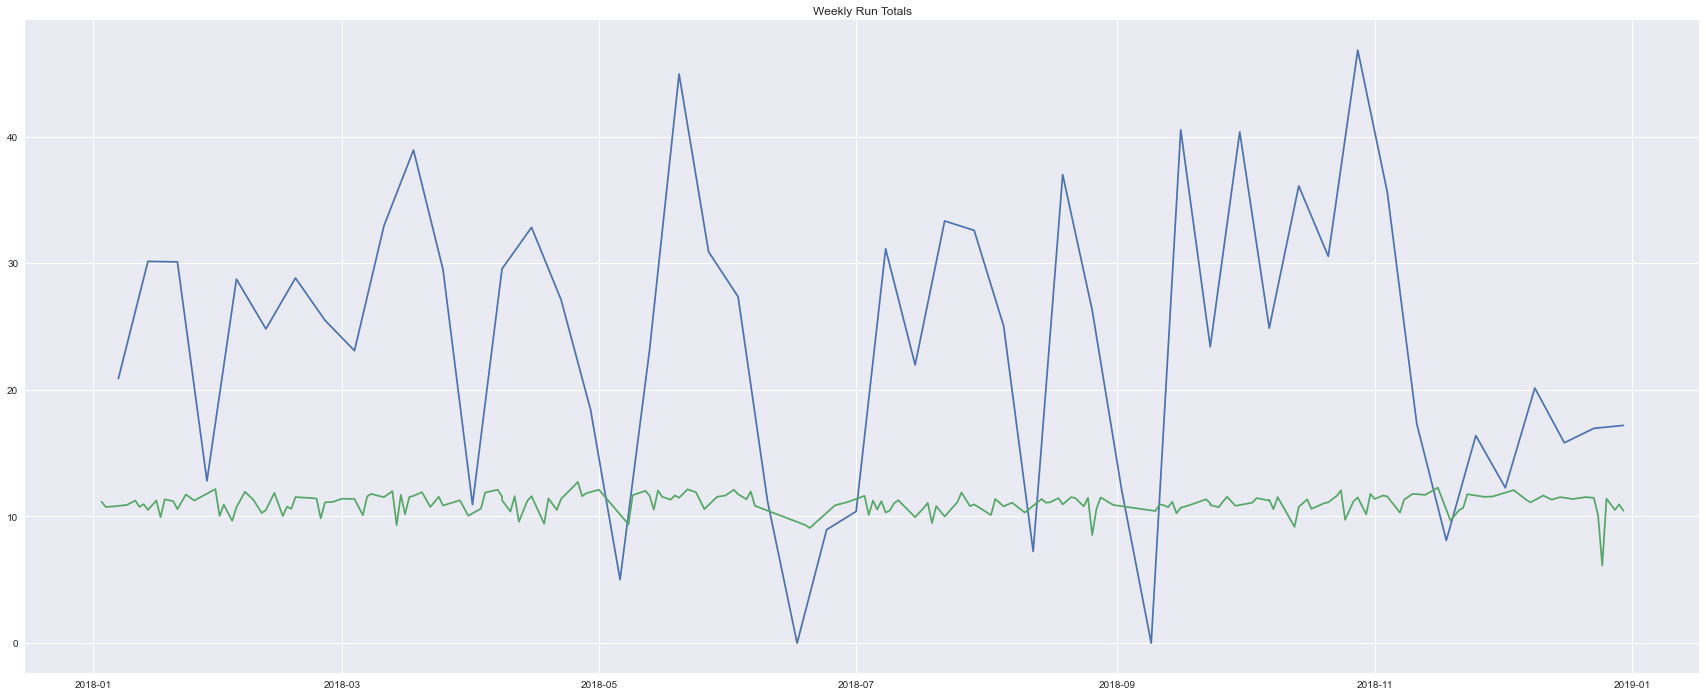

In [42]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['distance'].resample('W').sum())
plt.plot(run_2018['GAP_ft_s'])
plt.title('Weekly Run Totals')

Text(0.5, 1.0, 'Monthly Run Totals')

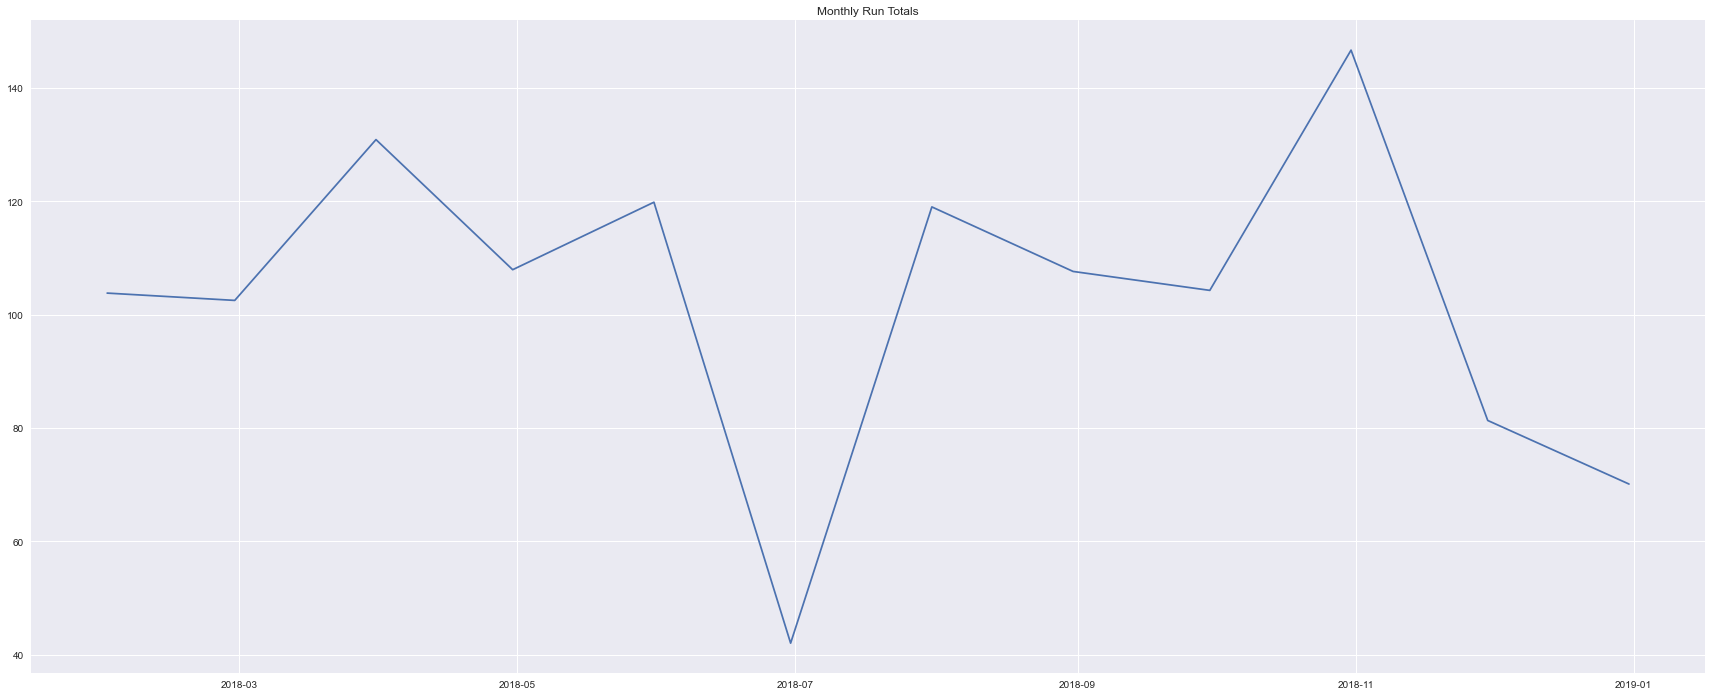

In [43]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['distance'].resample('M').sum())
plt.title('Monthly Run Totals')

Let's look a little deeper into 2018:


Text(0.5, 1.0, 'Run Speed/Intensity, 2018')

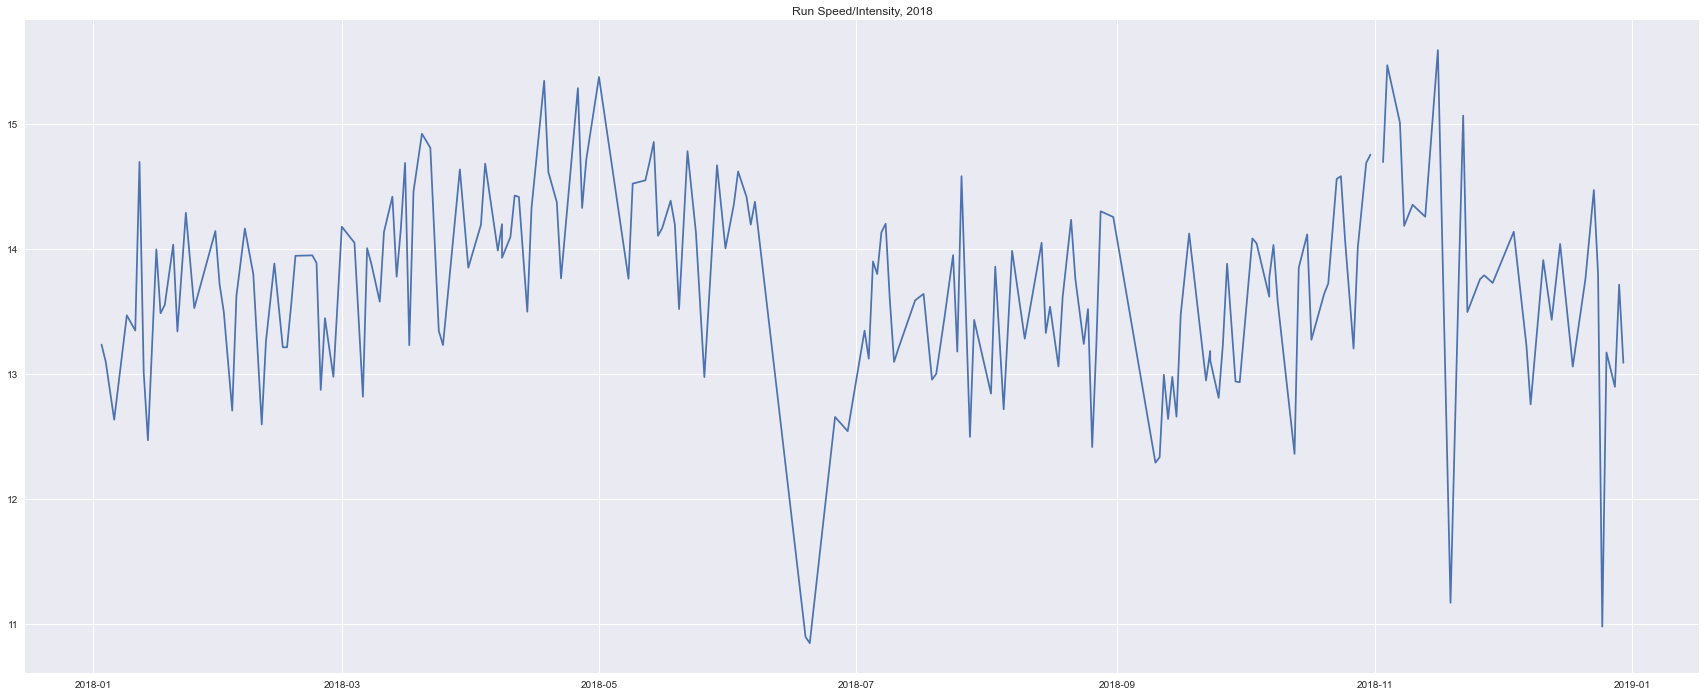

In [44]:
plt.figure(figsize = (30, 12))
plt.plot(run_2018['spd_ft_s']/(run_2018['intensity']))
plt.title('Run Speed/Intensity, 2018')

In [45]:
len(run_2018)

198

What do the moving averages look like?

In [46]:
speed = run_2019[['spd_ft_s']]

In [47]:
#calcuating 'Simple Moving Average' for 7 days:
run_2019['speed_SMA_7'] = run_2019['spd_ft_s'].rolling(window=7).mean()
#For 30 days:
run_2019['speed_SMA_30'] = run_2019['spd_ft_s'].rolling(window=30).mean()
#For 90 days:
run_2019['speed_SMA_90'] = run_2019['spd_ft_s'].rolling(window=90).mean()



In [48]:
run_2019.columns

Index(['Unnamed: 0', 'index', 'activity_type', 'favorite', 'title', 'distance',
       'calories', 'time', 'avg_hr', 'max_hr', 'aerobic_te', 'avg_run_cadence',
       'max_run_cadence', 'avg_pace', 'best_pace', 'elev_gain', 'elev_loss',
       'avg_stride_length', 'avg_vertical_ratio', 'avg_vertical_oscillation',
       'avg_ground_contact_time', 'avg_gct_balance', 'avg_run_cadence_1',
       'max_run_cadence_1', 'normalized_powerâ_npâ', 'lr_balance',
       'training_stress_scoreâ', 'max_avg_power_20_min', 'avg_power',
       'max_power', 'grit', 'flow', 'total_strokes', 'avg__swolf',
       'avg_stroke_rate', 'total_reps', 'total_sets', 'climb_time',
       'bottom_time', 'min_temp', 'surface_interval', 'decompression',
       'best_lap_time', 'number_of_laps', 'max_temp', 'avg_resp', 'min_resp',
       'max_resp', 'athlete_id', 'filetype', 'is_race', 'ft_per_mile',
       'intensity', 'spd_ft_s', 'spd_mph', 'GAP_ft_s', 'GAP_by_intensity',
       'speed_SMA_7', 'speed_SMA_30', 'speed

In [49]:
#Calculating the exponential moving average:
run_2019['EMA'] = speed.iloc[:,0].ewm(span=40,adjust=False).mean()



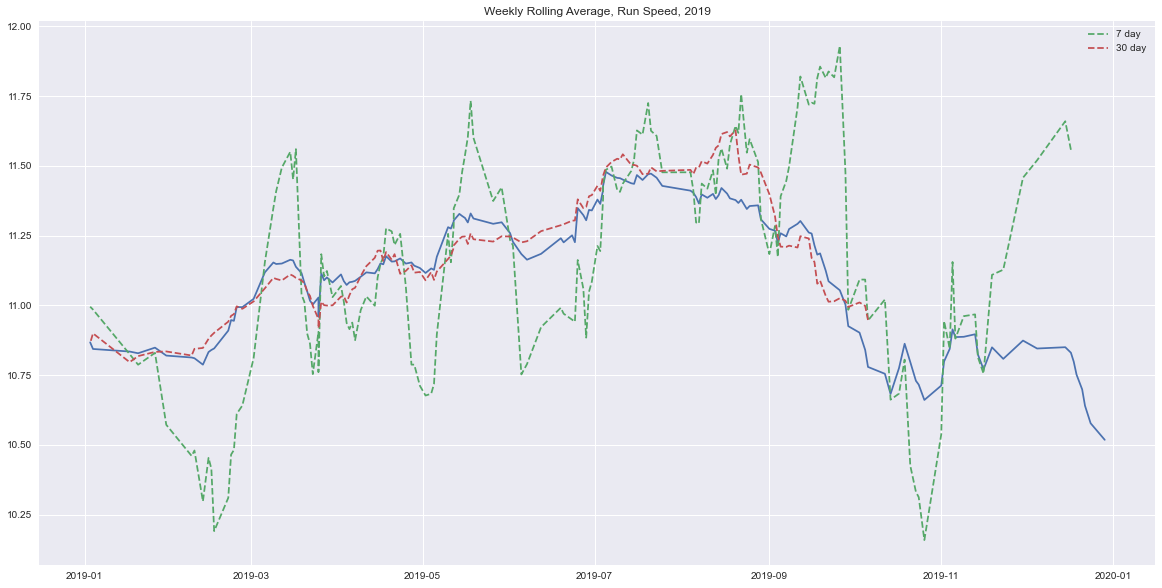

In [50]:
plt.figure(figsize = (20, 10))
#plt.plot(speed)
plt.plot(run_2019['EMA'])
plt.plot(run_2019['speed_SMA_7'], '--', label = '7 day')
plt.plot(run_2019['speed_SMA_30'], '--', label = '30 day')
#plt.plot(run_2019['speed_SMA_90'], '--', label = '90 day')
plt.title('Weekly Rolling Average, Run Speed, 2019')
plt.legend()

In [51]:
run_2019['EMA']

date
2019-12-29    10.517928
2019-12-24    10.577216
2019-12-22    10.640043
2019-12-21    10.698508
2019-12-19    10.751542
                ...    
2019-01-26    10.848300
2019-01-20    10.828128
2019-01-17    10.834286
2019-01-04    10.843490
2019-01-03    10.867245
Name: EMA, Length: 173, dtype: float64

In [52]:
#calcuating 'Simple Moving Average' for 7 days:
run_2019['distance_SMA_7'] = run_2019['distance'].rolling(window=7).mean()
#For 30 days:
run_2019['distance_SMA_30'] = run_2019['distance'].rolling(window=30).mean()
#For 90 days:
run_2019['distance_SMA_90'] = run_2019['distance'].rolling(window=90).mean()
#Sums:
run_2019['distance_SMS_7'] = run_2019['distance'].rolling(window=7).sum()
#For 30 days:
run_2019['distance_SMS_30'] = run_2019['distance'].rolling(window=30).sum()
#For 90 days:
run_2019['distance_SMS_90'] = run_2019['distance'].rolling(window=90).sum()

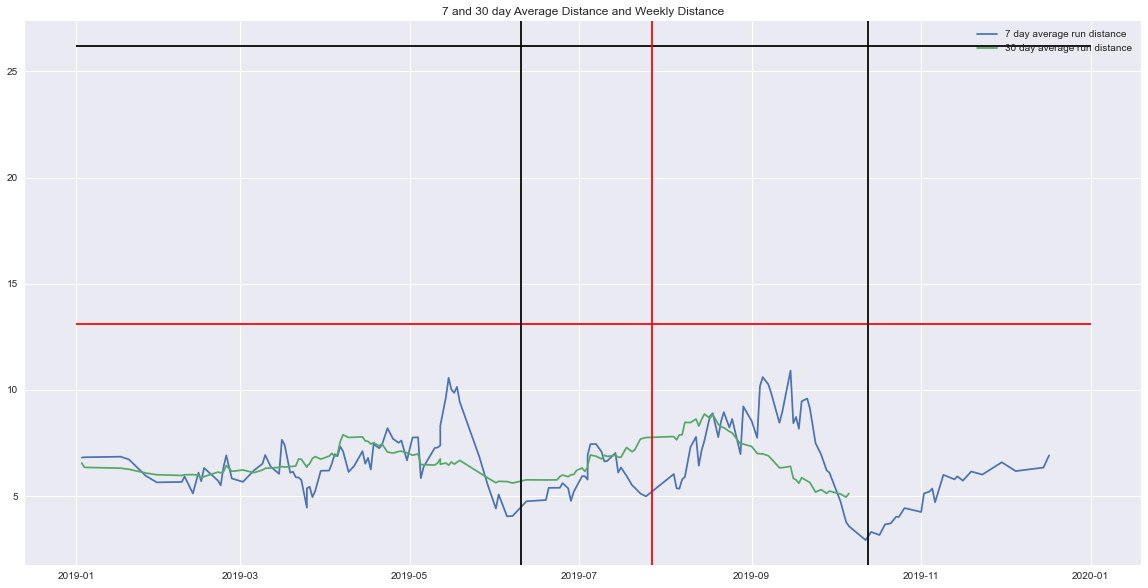

In [53]:
plt.figure(figsize = (20, 10))
plt.plot(run_2019['distance_SMA_7'], label = '7 day average run distance')
plt.plot(run_2019['distance_SMA_30'], label = '30 day average run distance')
plt.title('7 and 30 day Average Distance and Weekly Distance')
plt.axvline(dt.datetime(2019, 6, 10), color = 'black')
plt.axvline(dt.datetime(2019, 7, 27), color = 'red')
plt.axvline(dt.datetime(2019, 10, 13), color = 'black')
plt.hlines(26.2, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'black')
plt.hlines(13.1, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'red')
plt.legend()

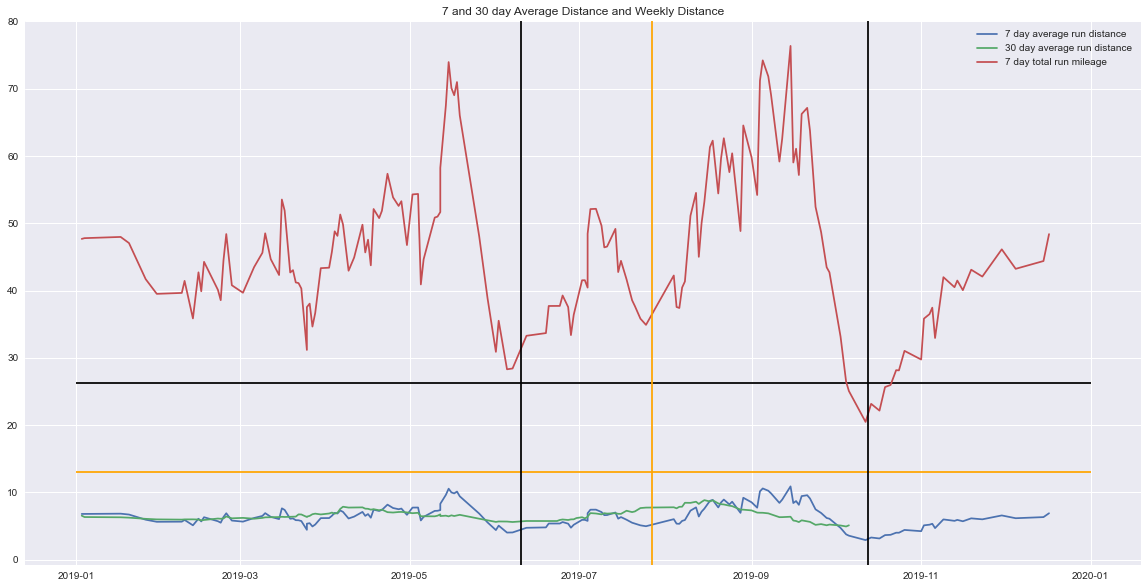

In [54]:
#Black lines are Marathon race dates and distances. Orange lines are half marathon dates and distances.
plt.figure(figsize = (20, 10))
plt.plot(run_2019['distance_SMA_7'], label = '7 day average run distance')
plt.plot(run_2019['distance_SMA_30'], label = '30 day average run distance')
plt.plot(run_2019['distance_SMS_7'], label = '7 day total run mileage')
plt.title('7 and 30 day Average Distance and Weekly Distance')
plt.axvline(dt.datetime(2019, 6, 10), color = 'black')
plt.axvline(dt.datetime(2019, 7, 27), color = 'orange')
plt.axvline(dt.datetime(2019, 10, 13), color = 'black')
plt.hlines(26.2, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'black')
plt.hlines(13.1, dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1), color = 'orange')
plt.legend()

In [55]:
run_2019.columns

Index(['Unnamed: 0', 'index', 'activity_type', 'favorite', 'title', 'distance',
       'calories', 'time', 'avg_hr', 'max_hr', 'aerobic_te', 'avg_run_cadence',
       'max_run_cadence', 'avg_pace', 'best_pace', 'elev_gain', 'elev_loss',
       'avg_stride_length', 'avg_vertical_ratio', 'avg_vertical_oscillation',
       'avg_ground_contact_time', 'avg_gct_balance', 'avg_run_cadence_1',
       'max_run_cadence_1', 'normalized_powerâ_npâ', 'lr_balance',
       'training_stress_scoreâ', 'max_avg_power_20_min', 'avg_power',
       'max_power', 'grit', 'flow', 'total_strokes', 'avg__swolf',
       'avg_stroke_rate', 'total_reps', 'total_sets', 'climb_time',
       'bottom_time', 'min_temp', 'surface_interval', 'decompression',
       'best_lap_time', 'number_of_laps', 'max_temp', 'avg_resp', 'min_resp',
       'max_resp', 'athlete_id', 'filetype', 'is_race', 'ft_per_mile',
       'intensity', 'spd_ft_s', 'spd_mph', 'GAP_ft_s', 'GAP_by_intensity',
       'speed_SMA_7', 'speed_SMA_30', 'speed

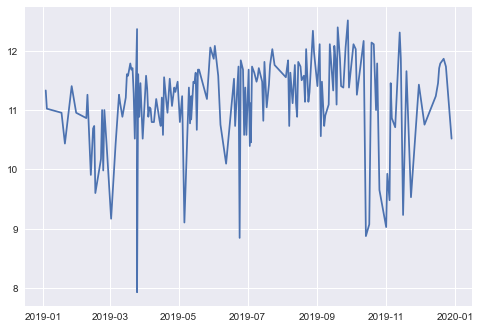

In [56]:
plt.plot(speed)

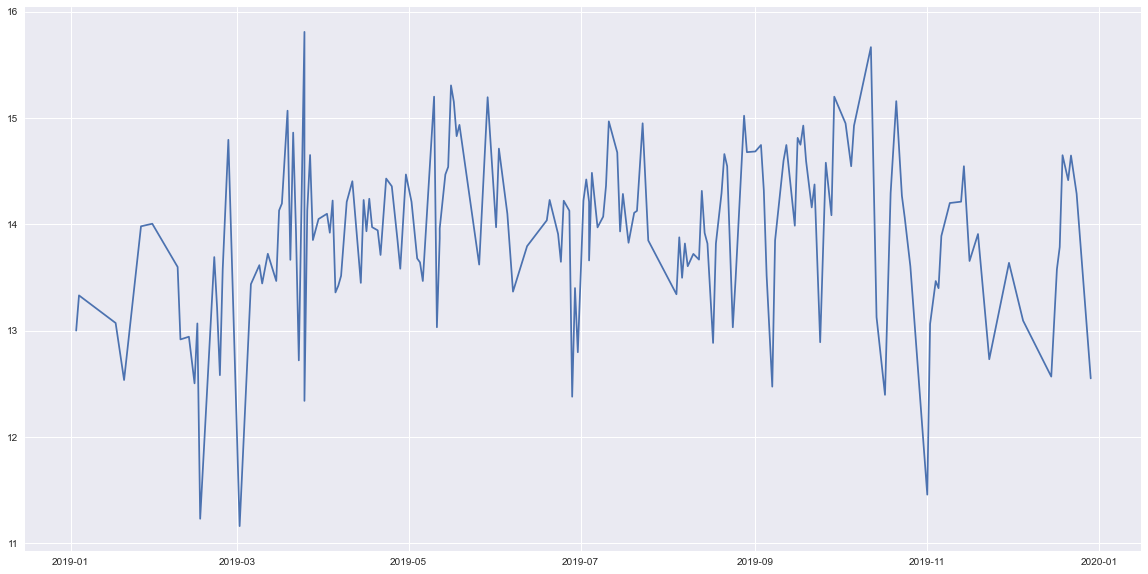

In [57]:
plt.figure(figsize = (20, 10))
plt.plot(run_2019['spd_ft_s']/(run_2019['intensity']))

## Using Pymc3 to Model the Increase in Pace over Time:

In [58]:
#Let's use this as a starting point to derive a seasonal model for run pace.
#If we assume the pattern of the average speed to be a bell curve throughout the season, or training period, perhaps we can model it.
#Lets build a simple bell curve estimator first:
def bell_curve(x):
    σ = 35
    μ = 185
    return 2*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))+100

In [59]:
var = np.linspace(0, 365, 1000)

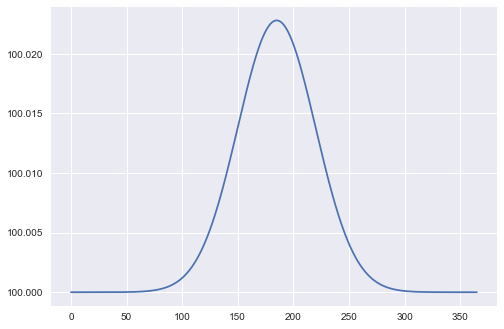

In [60]:
plt.plot(var, bell_curve(var))

In [61]:
#Ok moving on, can we add in variables to allow for local fluctuations?

In [62]:
def bell_curve2(x):
    σ = 35
    μ = 185
    return 5*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(x+ np.cos(5*x))+100 + np.random.randn(1000)

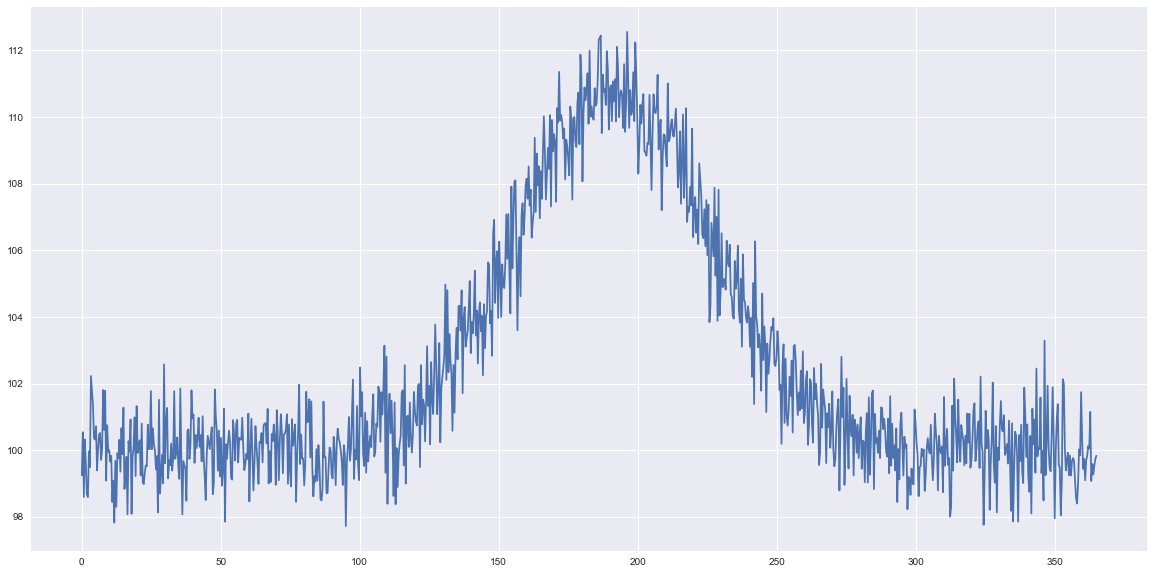

In [63]:
plt.figure(figsize = (20, 10))
plt.plot(var, bell_curve2(var))

In [64]:
obs = bell_curve2(var)
x = np.linspace(0, 365, 1000)

In [65]:
#Ok we can make a model with this, let's see how it does:

In [66]:
#build the model
with pm.Model() as guess:
    σ = pm.Uniform('σ', lower = 0, upper = 100)
    μ = pm.Uniform('μ', lower = 20, upper = 365)
    s = pm.Uniform('s', lower = 0, upper = 10)
    a = pm.Normal('a', mu = 5.0, sigma = 1)
    c = pm.Uniform('c', lower = 0, upper = 10)
    off = pm.Uniform('off', lower = 50, upper = 150)
    line = c*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(x+ np.cos(a*x))+off
    y = pm.Normal('y', mu = line, sd = s, observed = bell_curve2(x))
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, c, a, s, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


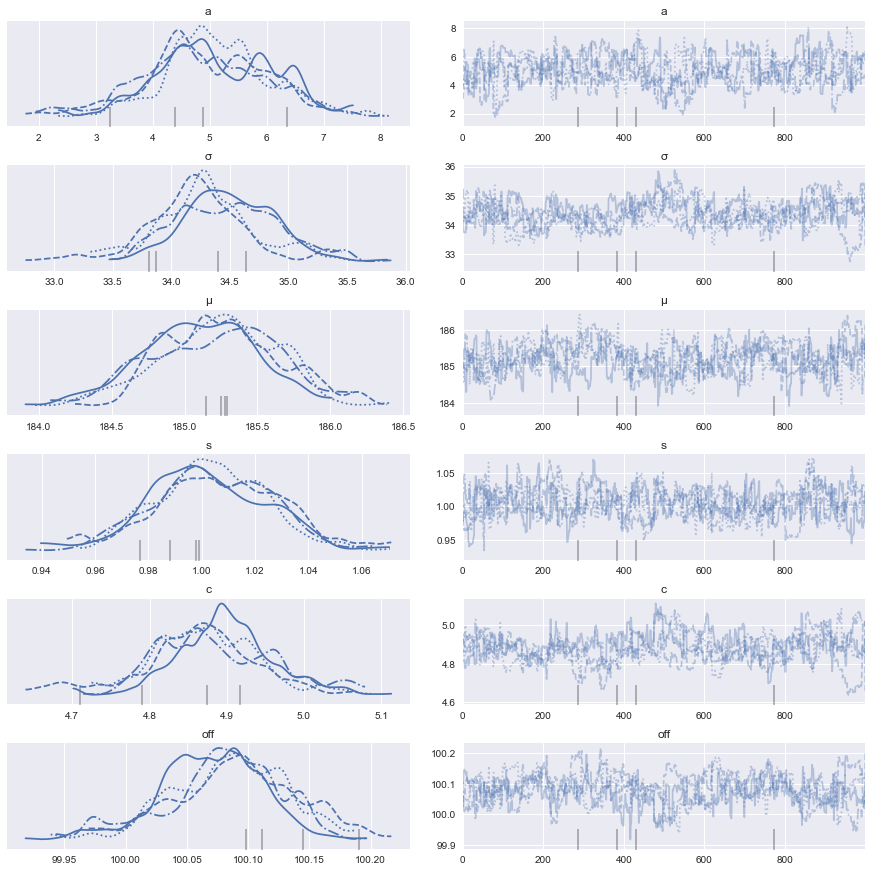

In [67]:
az.plot_trace(trace);

In [68]:
#Ok we have a model that looks like it can get close to a normal distribution with noise.

In [69]:
#Let's try it on our data.

In [70]:
x = np.linspace(0, 365, 173)

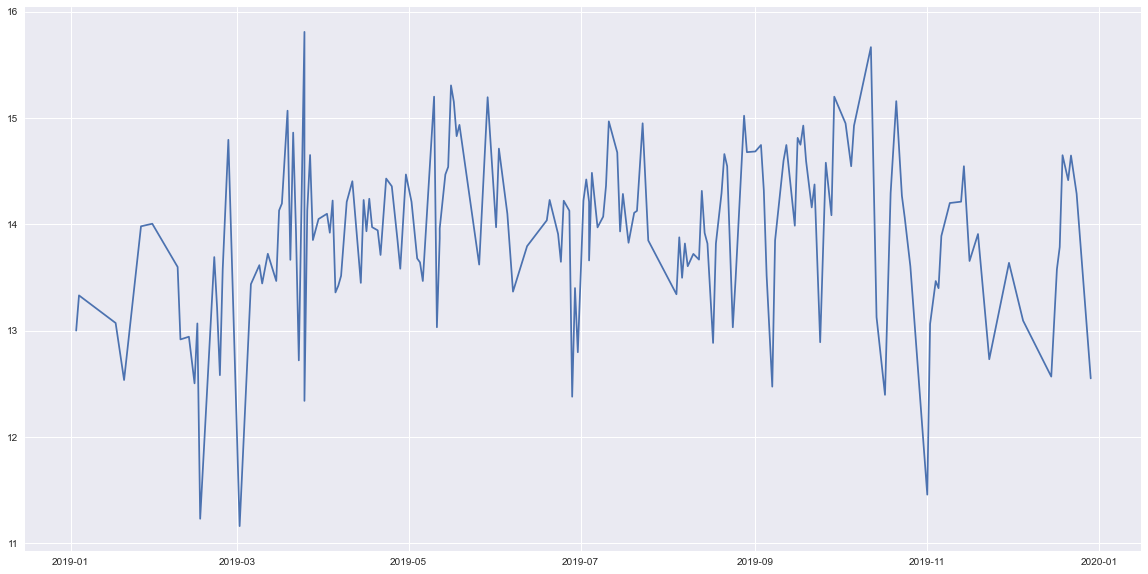

In [71]:
plt.figure(figsize = (20, 10))
plt.plot(run_2019['spd_ft_s']/(run_2019['intensity']))

In [72]:
with pm.Model() as run_model:
    σ = pm.Uniform('σ', lower = 0, upper = 100)
    μ = pm.Normal('μ', mu = 185.0, sigma = 173)
    s = pm.Uniform('s', lower = 0, upper = 10)
    a = pm.Uniform('a', lower = 0, upper = 50)
    c = pm.Uniform('c', lower = 0, upper = 10)
    z = pm.Uniform('z', lower = 0, upper = 10)
    r = pm.Uniform('r', lower = 0, upper = 10)
    off = pm.Uniform('off', lower = 0, upper = 15)
    line = c*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(r*x+ z*np.cos(a*x))+off
    y = pm.Normal('y', mu = line, sd = s, observed = (run_2019['spd_ft_s']/(run_2019['intensity'])))
    
    trace = pm.sample(365)

Only 365 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, r, z, c, a, s, μ, σ]


Sampling 4 chains for 1_000 tune and 365 draw iterations (4_000 + 1_460 draws total) took 134 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8966295414621117, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6149386063329303, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8905955652047801, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated numb

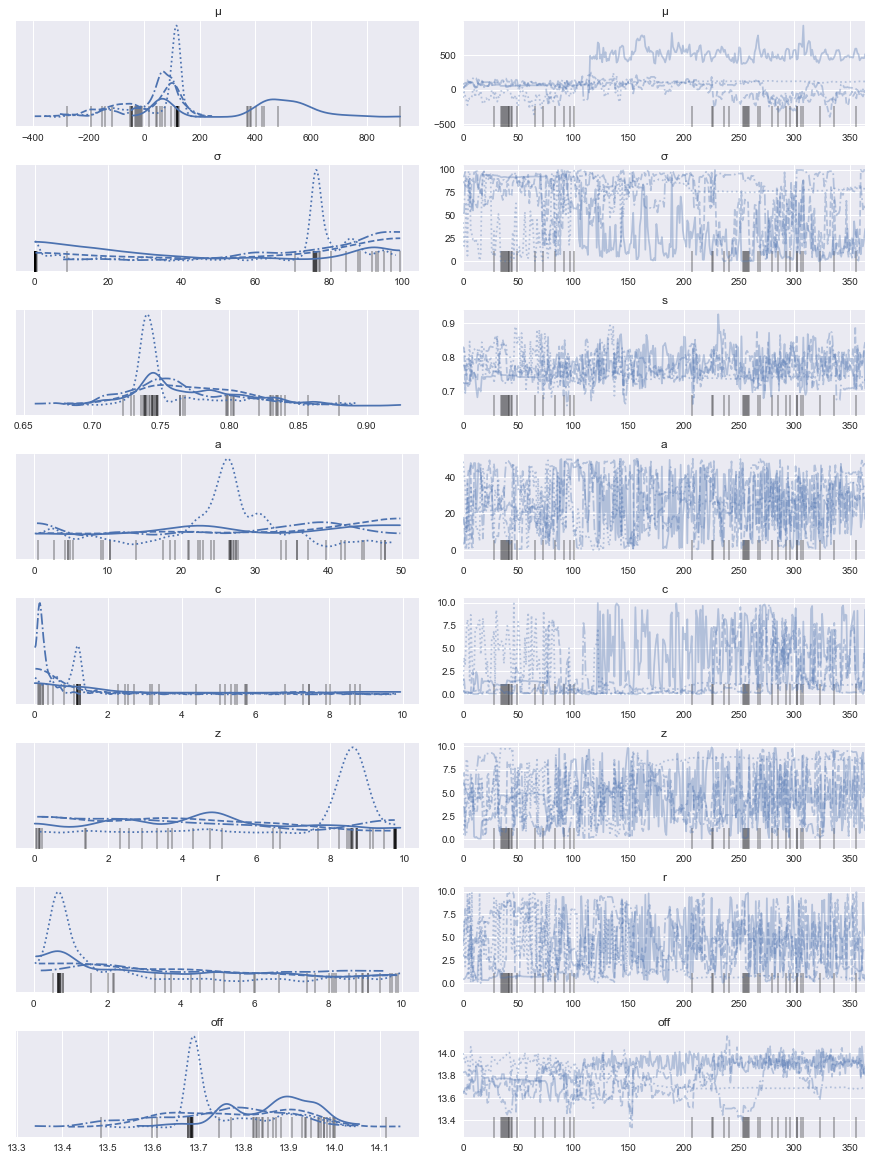

In [73]:
az.plot_trace(trace);

Try a more simple model:

In [74]:
with pm.Model() as run_model:
    σ = pm.Uniform('σ', lower = 0, upper = 100)
    μ = pm.Normal('μ', mu = 185.0, sigma = 173)
    s = pm.Uniform('s', lower = 0, upper = 10)
    c = pm.Uniform('c', lower = 0, upper = 5)
    off = pm.Uniform('off', lower = 0, upper = 15)
    line = c*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(np.cos(x))+off
    y = pm.Normal('y', mu = line, sd = s, observed = (run_2019['spd_ft_s']/(run_2019['intensity'])))
    
    trace = pm.sample(173)

Only 173 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, c, s, μ, σ]


Sampling 4 chains for 1_000 tune and 173 draw iterations (4_000 + 692 draws total) took 16 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


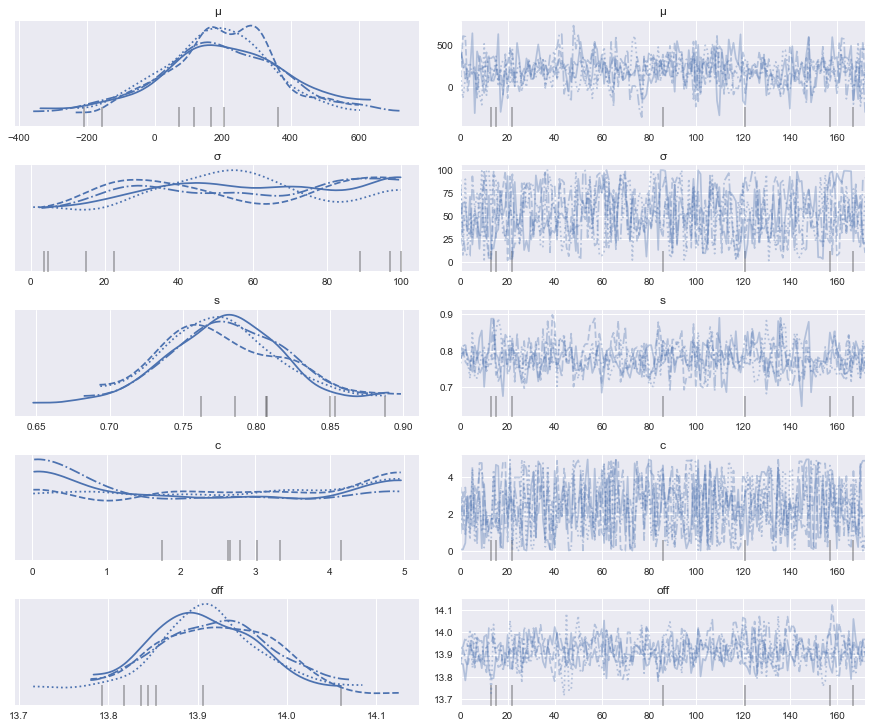

In [75]:
az.plot_trace(trace);

## Forecasting and SARIMAX with PYMC3

In [80]:
#First let's fill in the missing dates paces, with previous day's paces:

In [76]:
best_speed = run_2019['spd_ft_s']/(run_2019['intensity'])

In [77]:
type(best_speed)

pandas.core.series.Series

In [78]:
best_speed.sort_index(ascending = True, inplace = True)

In [79]:
best_speed.index

DatetimeIndex(['2019-01-03', '2019-01-04', '2019-01-17', '2019-01-20',
               '2019-01-26', '2019-01-30', '2019-02-08', '2019-02-09',
               '2019-02-12', '2019-02-14',
               ...
               '2019-11-30', '2019-12-05', '2019-12-15', '2019-12-17',
               '2019-12-18', '2019-12-19', '2019-12-21', '2019-12-22',
               '2019-12-24', '2019-12-29'],
              dtype='datetime64[ns]', name='date', length=173, freq=None)

In [80]:
full_yr_date = pd.date_range(start = '2019-01-01', end='2019-12-31')

In [81]:
len(full_yr_date)

365

In [82]:
type(full_yr_date)

pandas.core.indexes.datetimes.DatetimeIndex

In [83]:
best_speed.index.value_counts()

2019-03-25    2
2019-05-12    2
2019-07-04    2
2019-07-02    1
2019-04-30    1
             ..
2019-02-12    1
2019-11-23    1
2019-10-03    1
2019-06-23    1
2019-02-21    1
Name: date, Length: 170, dtype: int64

In [84]:
#Looks like we have to clean up the index to have just one entry per day

In [85]:
best_speed['2019-07-04']

date
2019-07-04    14.212331
2019-07-04    13.660765
dtype: float64

In [86]:
#Let's just drop the first one in each case.

In [87]:
best_speed = best_speed[~best_speed.index.duplicated(keep='first')]

In [88]:
len(best_speed)

170

In [89]:
# We will pad, so that the speed does not increase unless the athlete increases speed on their next run:
best_speed = best_speed.reindex(index = full_yr_date, method = 'pad')

In [90]:
len(best_speed)

365

In [91]:
best_speed = best_speed.dropna()

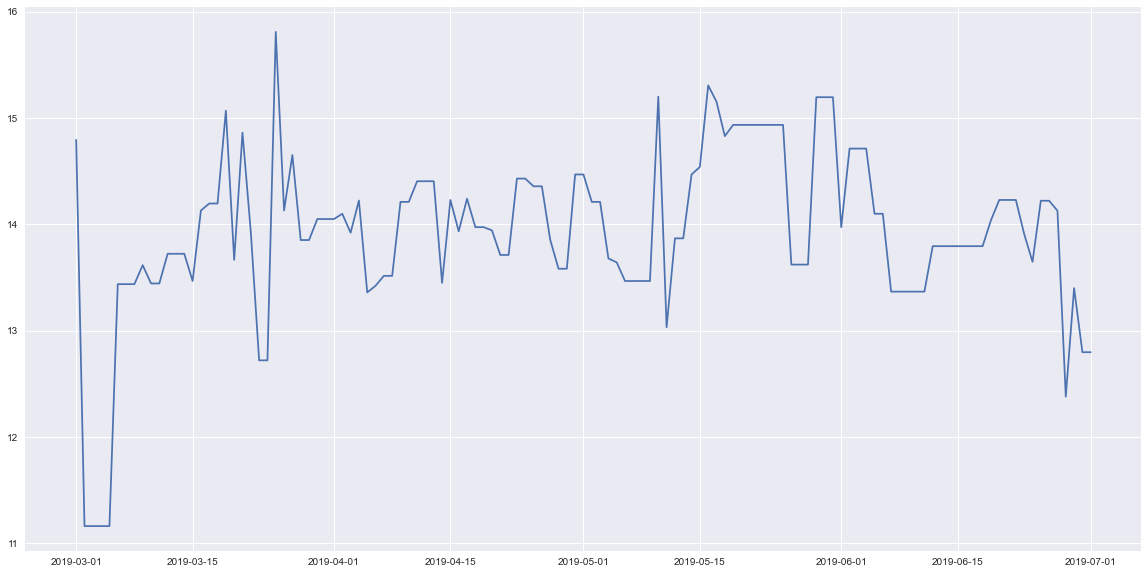

In [92]:
plt.figure(figsize = (20, 10))
plt.plot(best_speed['2019-03-01':'2019-07-01'])

In [93]:
best_speed['2019-03-01':'2019-07-01']

2019-03-01    14.794778
2019-03-02    11.162132
2019-03-03    11.162132
2019-03-04    11.162132
2019-03-05    11.162132
                ...    
2019-06-27    14.128199
2019-06-28    12.379268
2019-06-29    13.400635
2019-06-30    12.797487
2019-07-01    12.797487
Freq: D, Length: 123, dtype: float64

In [94]:
#Let's try our model above:
x = np.linspace(0, 123, 123)

with pm.Model() as run_model:
    σ = pm.Uniform('σ', lower = 0, upper = 100)
    μ = pm.Normal('μ', mu = 60.0, sigma = 30)
    s = pm.Uniform('s', lower = 0, upper = 10)
    c = pm.Uniform('c', lower = 0, upper = 5)
    off = pm.Uniform('off', lower = 0, upper = 15)
    line = c*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(np.cos(x))+off
    y = pm.Normal('y', mu = line, sd = s, observed = (best_speed['2019-03-01':'2019-07-01']))
    
    trace = pm.sample(1000, target_accept = 0.96)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, c, s, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


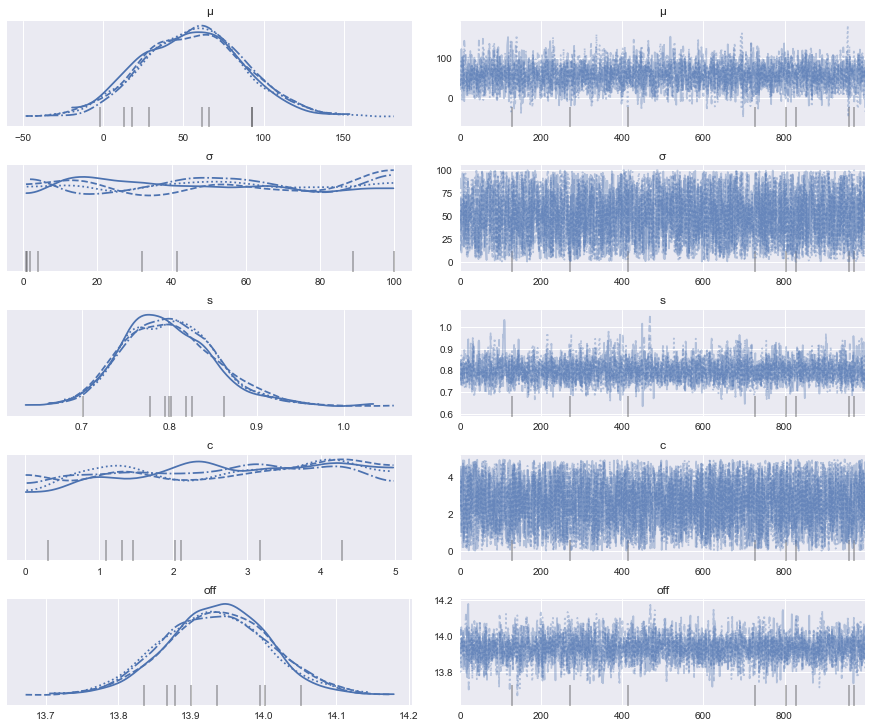

In [95]:
az.plot_trace(trace);

In [96]:
type(best_speed)

pandas.core.series.Series

In [97]:
best_df = pd.DataFrame(best_speed)

In [98]:
best_df.columns = ['avg_speed']

In [99]:
best_df['pace_SMA_7'] = best_df['avg_speed'].rolling(window=7).mean()

In [100]:
best_df.head(10)

avg_speed  pace_SMA_7
2019-01-03  13.000990         NaN
2019-01-04  13.331829         NaN
2019-01-05  13.331829         NaN
2019-01-06  13.331829         NaN
2019-01-07  13.331829         NaN
2019-01-08  13.331829         NaN
2019-01-09  13.331829   13.284566
2019-01-10  13.331829   13.331829
2019-01-11  13.331829   13.331829
2019-01-12  13.331829   13.331829

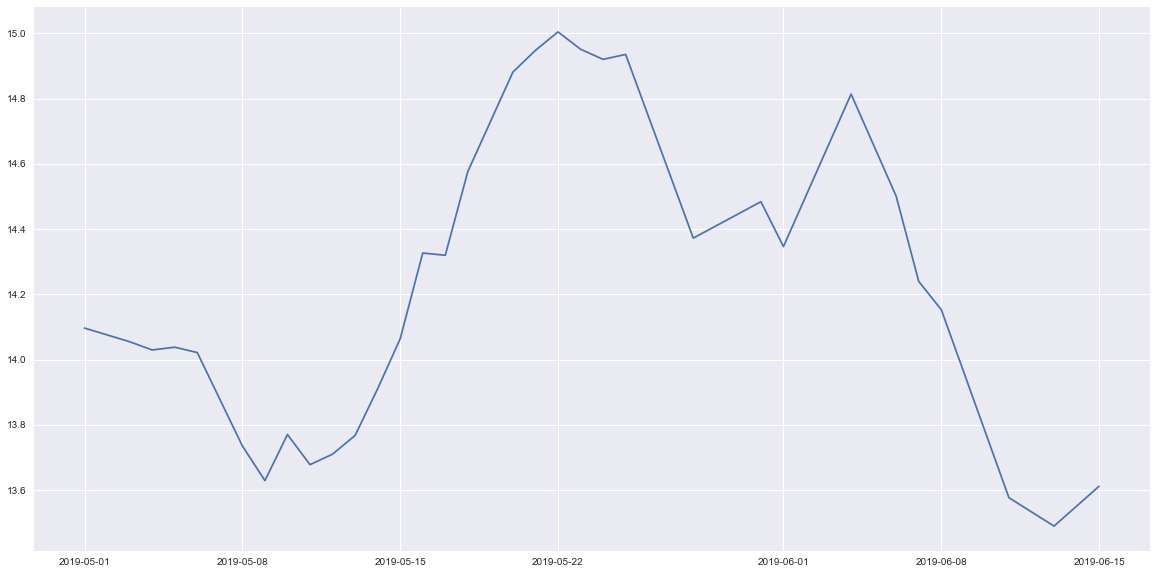

In [101]:
plt.figure(figsize = (20, 10))
plt.plot(best_df['2019-05-01':'2019-06-15']['pace_SMA_7'])

In [102]:
len(best_df['2019-05-01':'2019-06-15']['pace_SMA_7'])

46

In [103]:
#Let's try our model above:
x = np.linspace(0, 46, 46)

with pm.Model() as run_model:
    σ = pm.Uniform('σ', lower = 0, upper = 46)
    μ = pm.Normal('μ', mu = 26.0, sigma = 5)
    s = pm.Uniform('s', lower = 0, upper = 10)
    c = pm.Uniform('c', lower = 0, upper = 5)
    off = pm.Uniform('off', lower = 0, upper = 15)
    line = c*(1/(σ * np.sqrt(2*np.pi)))*np.exp((-(x - μ)**2)/(2 * σ**2))*(np.cos(x))+off
    y = pm.Normal('y', mu = line, sd = s, observed = (best_df['2019-05-01':'2019-06-15']['pace_SMA_7']))
    
    trace = pm.sample(1000, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, c, s, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


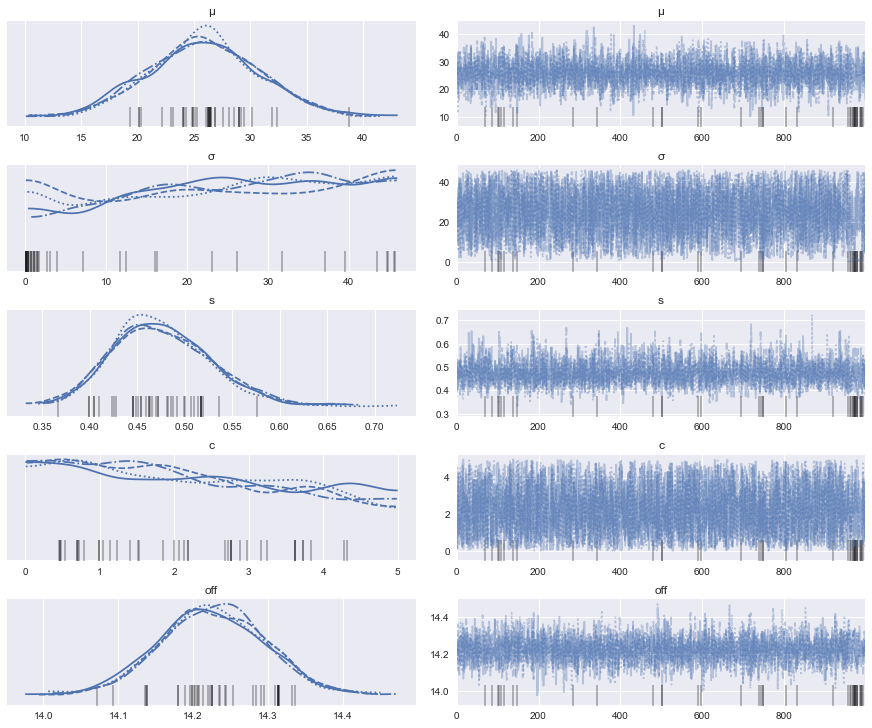

In [104]:
az.plot_trace(trace);

In [105]:
#Let's try to fit a SARIMAX from statsmodels with forecasting:

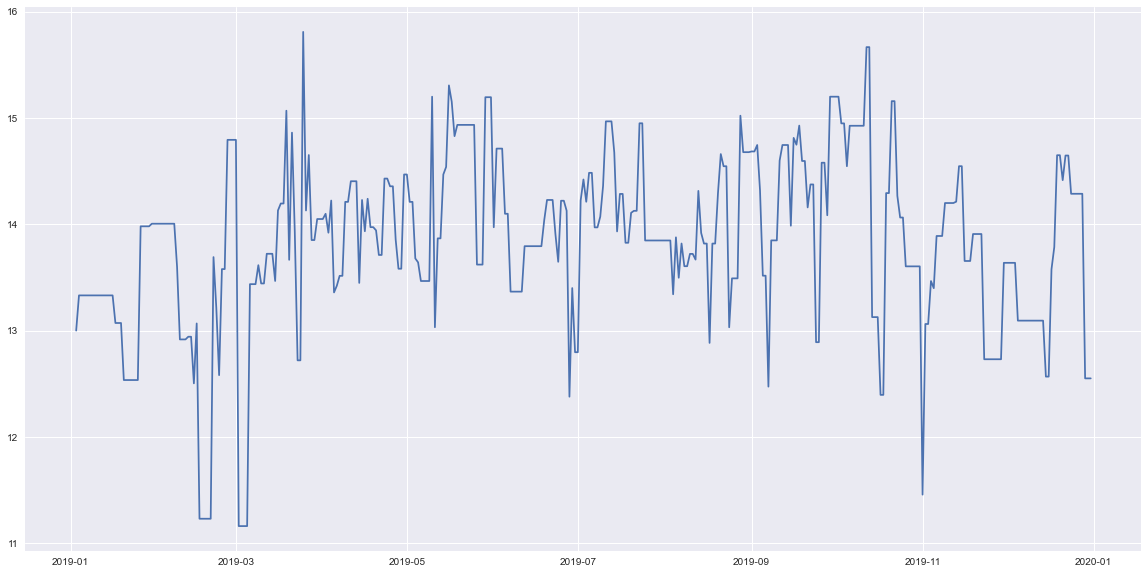

In [106]:
plt.figure(figsize = (20, 10))
plt.plot(best_df['avg_speed'])

In [107]:
#Calculating the exponential moving average:
best_df['EMA'] = best_df.iloc[:,0].ewm(span=30,adjust=False).mean()

In [108]:
best_df.loc['2019-07-27']

avg_speed     13.848318
pace_SMA_7    14.242933
EMA           14.169238
Name: 2019-07-27 00:00:00, dtype: float64

In [109]:
# 30-day Exponential moving average * .9 intensity (half marathon pace) is within 6s/mile. Best so far.

## Wrapping PYMC3 around Statsmodels

In [110]:
#In this section I am going to attempt to wrap pymc3 around statsmodels, using the SARIMAX model from statsmodels.
#Then we pass the tensors to PYMC3 and let it find the equation for the lag coefficients and standard dev.

In [111]:
mod = sm.tsa.statespace.SARIMAX(best_df['avg_speed'], order=(1, 0, 1))
res_mle = mod.fit(disp=False)
print(res_mle.summary())

                               SARIMAX Results                                
Dep. Variable:              avg_speed   No. Observations:                  363
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -334.498
Date:                Mon, 01 Mar 2021   AIC                            674.997
Time:                        14:26:42   BIC                            686.680
Sample:                    01-03-2019   HQIC                           679.641
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.002    580.441      0.000       0.996       1.003
ma.L1         -0.2486      0.049     -5.034      0.000      -0.345      -0.152
sigma2         0.3636      0.013     27.706      0.0

In [112]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
predict_mle_ci



lower avg_speed  upper avg_speed
2019-01-03       -23.616402        23.616402
2019-01-04        11.765912        14.201477
2019-01-05        12.056857        14.424898
2019-01-06        12.117832        14.481897
2019-01-07        12.132539        14.496359
...                     ...              ...
2019-12-27        13.097512        15.461316
2019-12-28        13.093497        15.457301
2019-12-29        13.092499        15.456303
2019-12-30        11.788917        14.152721
2019-12-31        11.464870        13.828674

[363 rows x 2 columns]

In [113]:
lower = predict_mle_ci['lower avg_speed']
upper = predict_mle_ci['upper avg_speed']

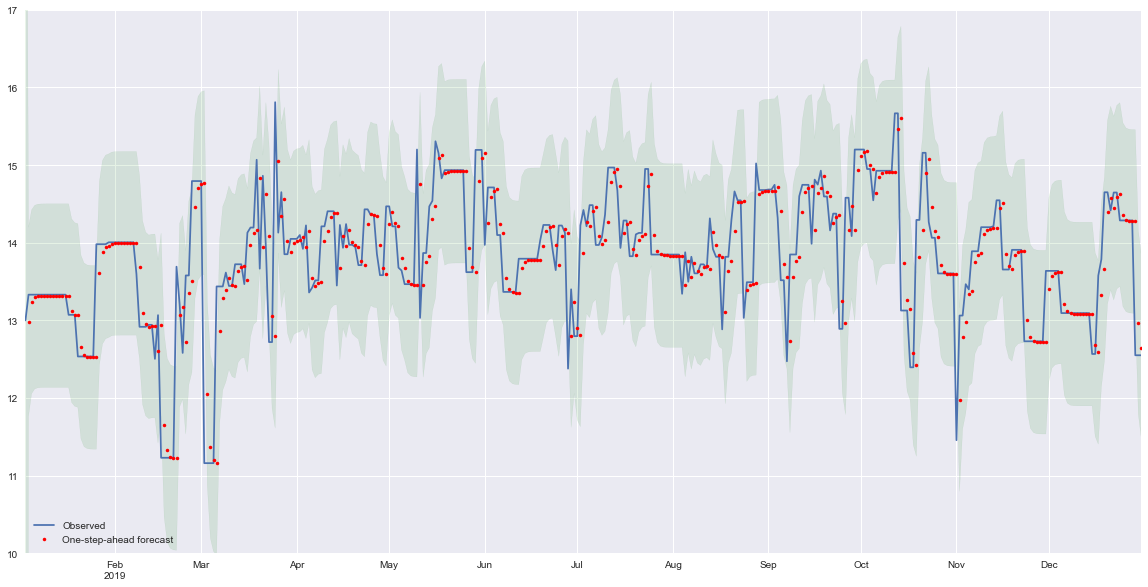

In [114]:

# Graph
fig, ax = plt.subplots(figsize=(20,10))

# Plot data points
best_df['avg_speed'].plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_mle_ci.index, lower, upper, color='g', alpha=0.1)
ax.set_ylim(bottom = 10, top = 17)
ax.legend(loc='lower left')
plt.show()


## SARIMA Results:

In [115]:
predict_mle.predicted_mean['2019-07-27']

13.900165006677726

In [116]:
#So using this as our 100% intensity, our half marathon pace would expect to be at the 90% intensity. What is that value?

In [117]:
0.90*predict_mle.predicted_mean['2019-07-27']

12.510148506009953

In [118]:
#This converts to about 7:02/mile, where race pace was 6:45/mile. Difference of about 5%. 

In [119]:
#Let's see if we can create a smoothed prediction line for pace, using a wrapper for statsmodels and pymc3:


In [120]:
#Wrappers from https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_pymc3.html

class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

In [121]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600   # number of "burn-in points" (which will be discarded)

In [122]:
mod = sm.tsa.statespace.SARIMAX(best_df['avg_speed'], order=(1, 0, 1))
loglike = Loglike(mod)

In [123]:
loglike.itypes

[TensorType(float64, vector)]

In [124]:
loglike.otypes

[TensorType(float64, scalar)]

In [125]:
import theano
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'
theano.config.compute_test_value = 'warn'

In [126]:
with pm.Model():
    # Priors
    arL1 = pm.Uniform('ar.L1', -0.99, 0.99)
    maL1 = pm.Uniform('ma.L1', -0.99, 0.99)
    sigma2 = pm.InverseGamma('sigma2', 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a Potential Dist for the likelihood
    pm.Potential('likelihood', loglike(theta))
    
    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, cores=1, discard_tuned_samples=True) #, start = {'ar.L1':0, 'ma.L1':0, 'sigma2':(np.log(3.5-2) - np.log(4-3.5))}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 110 seconds.
The acceptance probability does not match the target. It is 0.8837366123565555, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


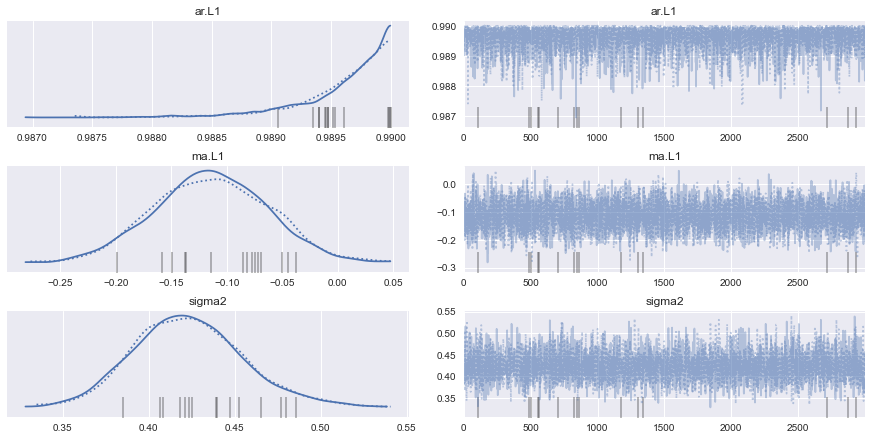

In [127]:
az.plot_trace(trace);

In [128]:
#Looks pretty good, and these are near the values we found earlier in the SARIMAX model.

In [138]:
az.summary(trace)['mean']

ar.L1     0.990
ma.L1    -0.114
sigma2    0.423
Name: mean, dtype: float64

In [139]:
params = az.summary(trace)['mean'].values

In [140]:
res_bayes = mod.smooth(params)

In [141]:
#Predicting and getting the confidence intervals again:
predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci['lower avg_speed']
upper = predict_bayes_ci['upper avg_speed']

## Bayesian Results:

In [142]:
predict_bayes.predicted_mean['2019-07-27']

13.706042874629308

In [143]:
.90*predict_bayes.predicted_mean['2019-07-27'] #This is in ft/s

12.335438587166378

In [144]:
#Comes out to 7:08/mile. Not as close as the original ARIMA model.

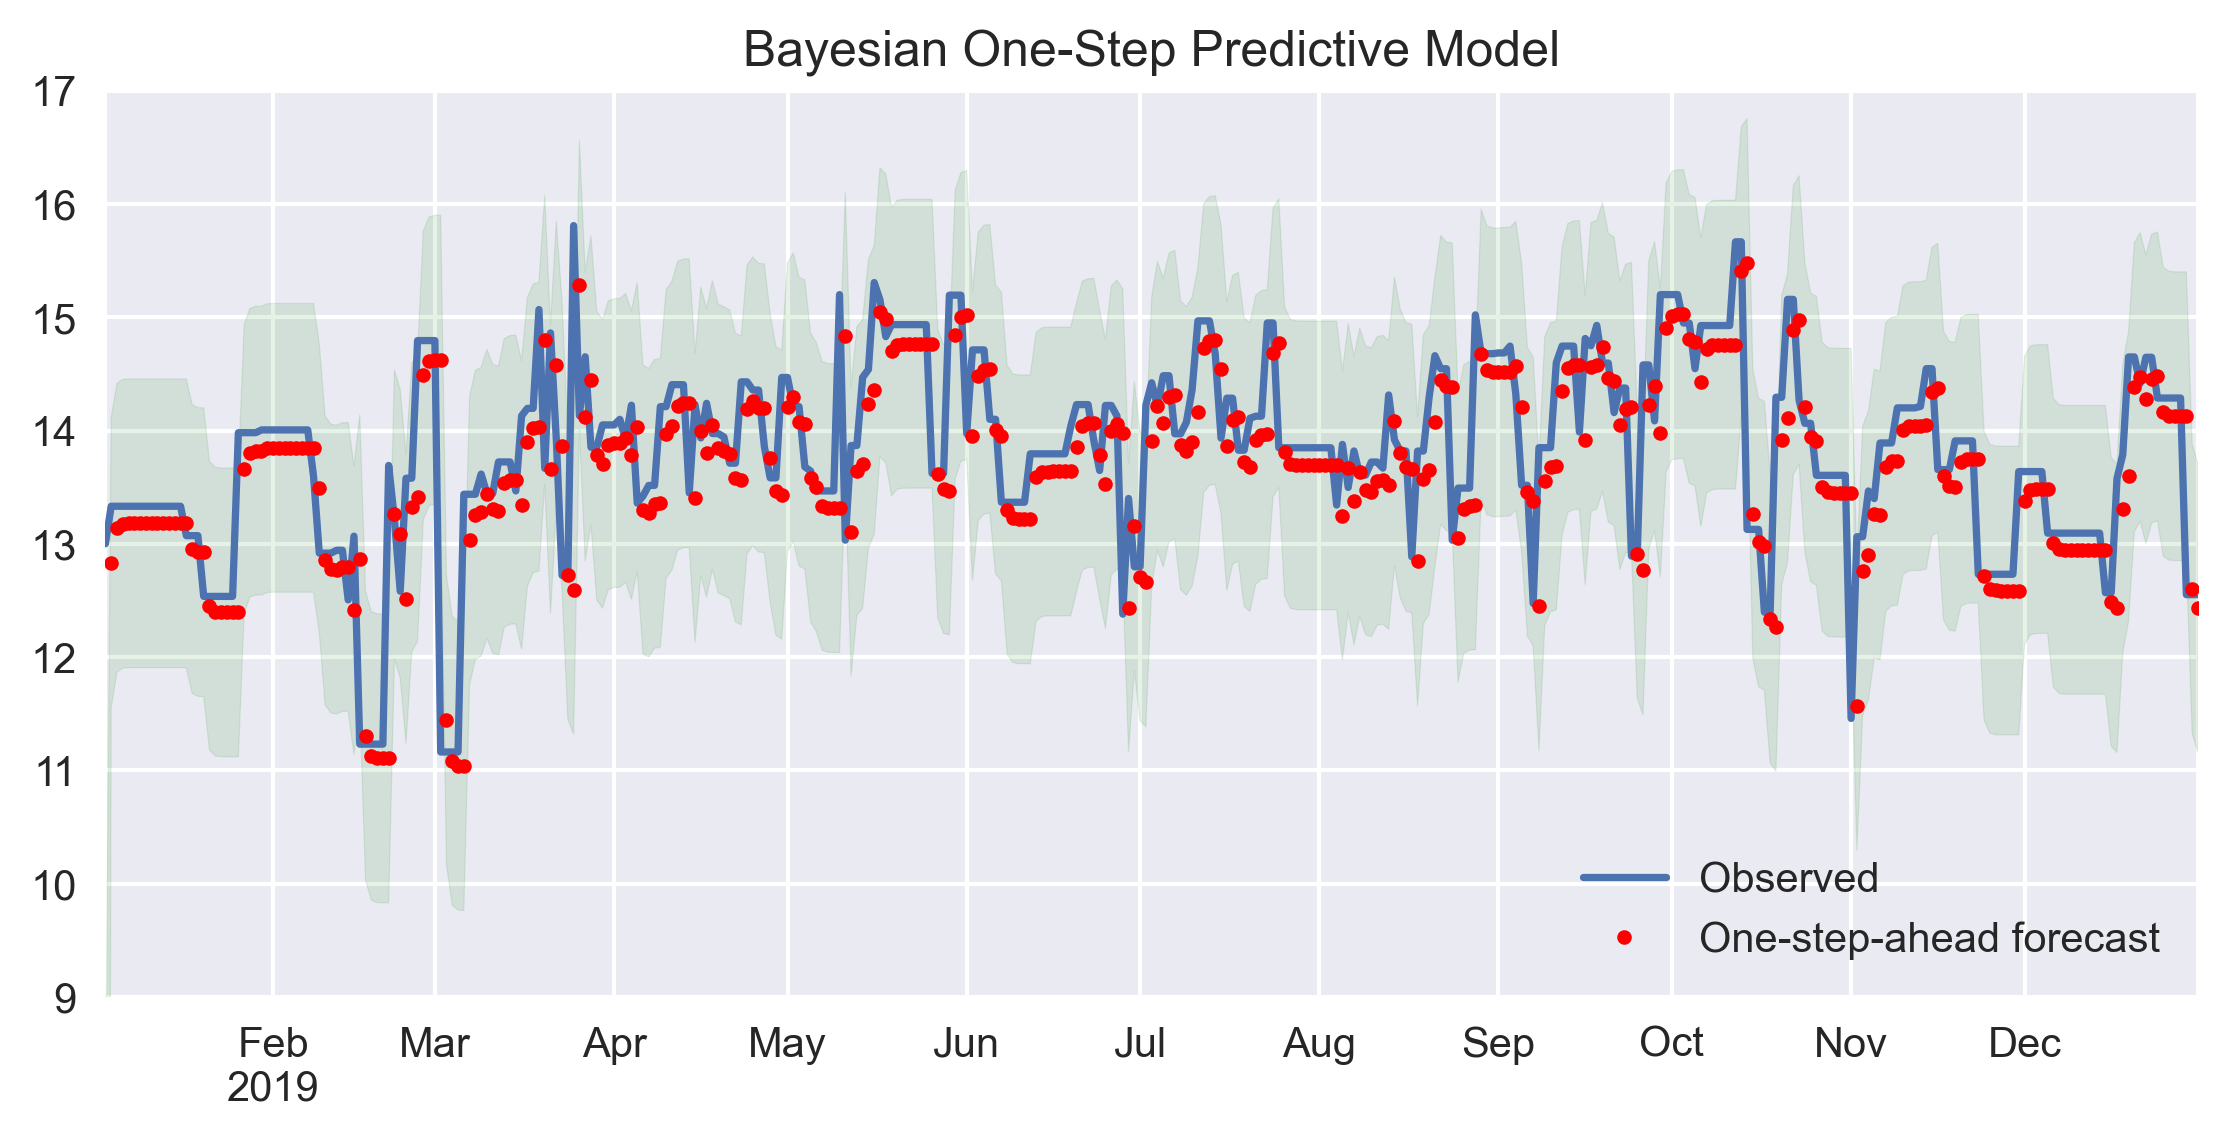

In [145]:
fig.clear(True)
ax.clear()
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
best_df['avg_speed'].plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
ax.fill_between(predict_bayes_ci.index, lower, upper, color='g', alpha=0.1)
ax.set_ylim(bottom = 9, top = 17)
ax.legend(loc='lower right')
plt.title('Bayesian One-Step Predictive Model')
plt.show()

In [146]:
#Combining this with a random walk distribution:
#Note: this may not prove as good a fit, but we will see!

In [147]:
uc_model = sm.tsa.UnobservedComponents(best_df['avg_speed'], 'rwalk', simple_differencing=True, autoregressive=1)
res_uc_mle = uc_model.fit()
print(res_uc_mle.summary())

                        Unobserved Components Results                         
Dep. Variable:              avg_speed   No. Observations:                  363
Model:                    random walk   Log Likelihood                -312.725
                              + AR(1)   AIC                            631.450
Date:                Mon, 01 Mar 2021   BIC                            643.125
Time:                        14:35:04   HQIC                           636.091
Sample:                    01-03-2019                                         
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     0.0028      0.003      0.973      0.330      -0.003       0.008
sigma2.ar        0.3161      0.017     19.075 

In [148]:
ndraws = 1500
nburn = 500

In [149]:
#Using the same model structure as before:
loglike_uc = Loglike(uc_model)

with pm.Model():
    # Priors
    sigma2level = pm.InverseGamma('sigma2.level', 3, 0.5)
    sigma2ar = pm.InverseGamma('sigma2.ar', 3, 1)
    arL1 = pm.Uniform('ar.L1', -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([sigma2level, sigma2ar, arL1])

    # use a Potential function here in place of DensityDist
    pm.Potential('likelihood', loglike(theta_uc))

    # Draw samples
    trace_uc = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ar.L1, sigma2.ar, sigma2.level]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 10329 seconds.
The acceptance probability does not match the target. It is 0.9999999999998788, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1037 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [150]:
#With so many divergences I don't expect a nice graph:

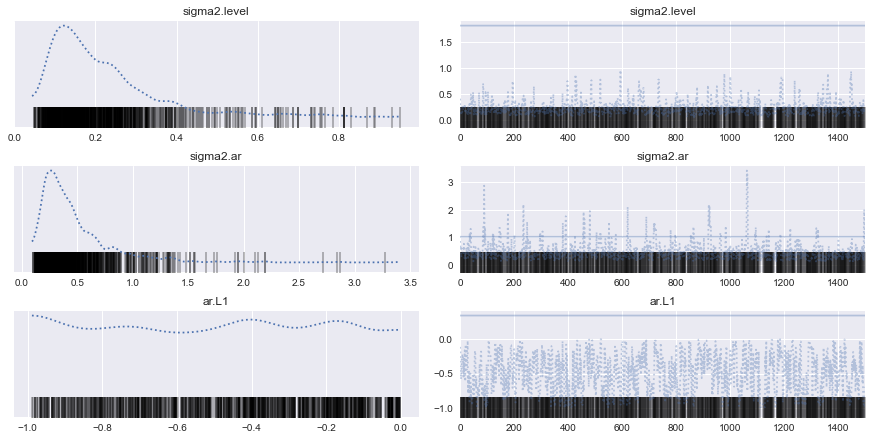

In [151]:
az.plot_trace(trace_uc);

In [ ]:
#AIC indicated that the model might have been better, but we should be careful with how this looks.

In [152]:
az.summary(trace_uc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma2.level  1.015  0.799   0.096    1.807      0.560    0.476       3.0   
sigma2.ar     0.747  0.365   0.161    1.017      0.199    0.155       4.0   
ar.L1        -0.079  0.465  -0.882    0.339      0.300    0.245       3.0   

              ess_tail  r_hat  
sigma2.level       2.0   2.23  
sigma2.ar         60.0   2.24  
ar.L1            261.0   2.23

In [ ]:
#Let's try to look at the smoothed curve:

In [153]:
params = az.summary(trace_uc)['mean'].values

In [154]:
bayes_uc_results = uc_model.smooth(params)

<AxesSubplot:>

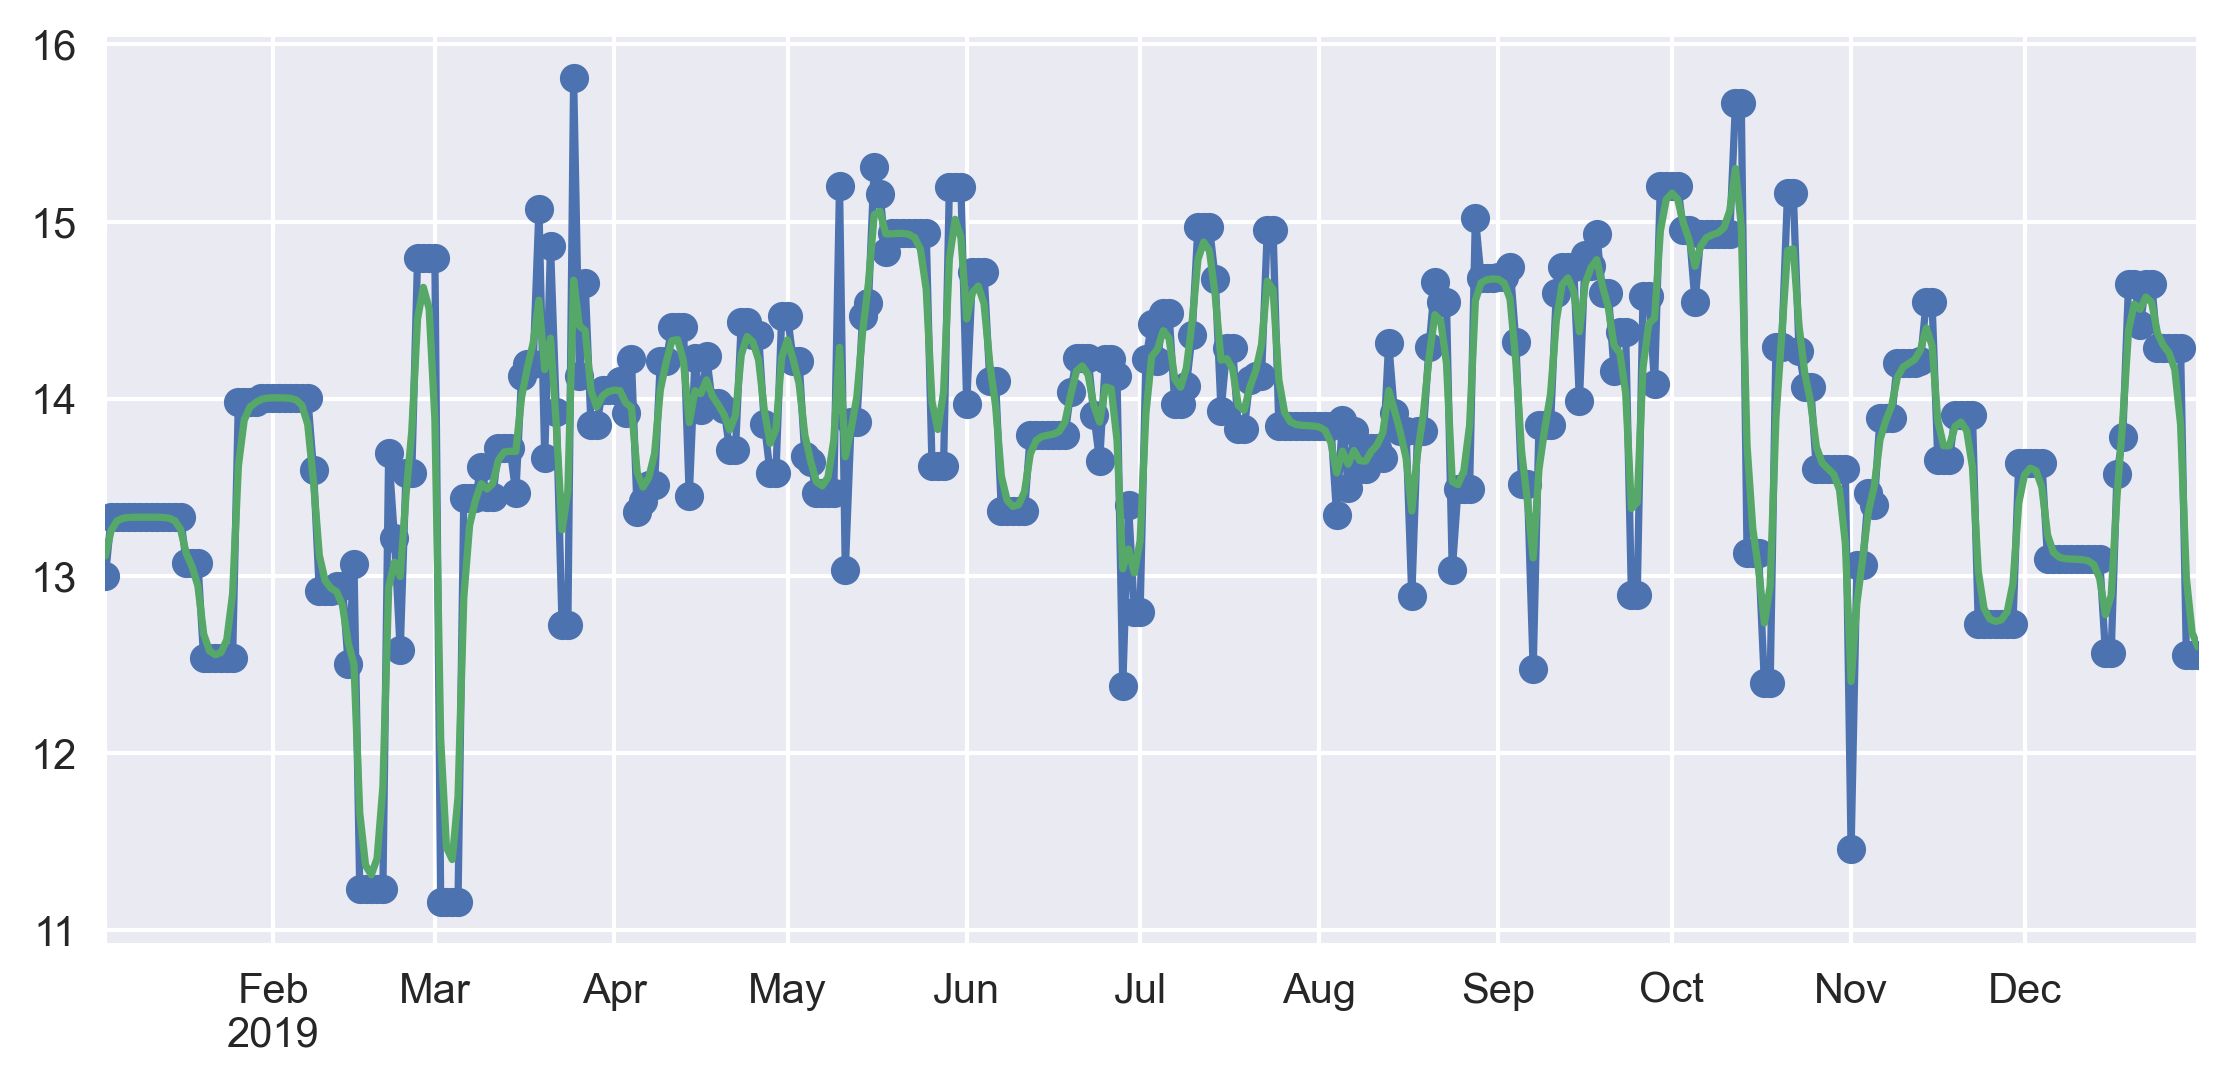

In [155]:
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

best_df['avg_speed'].plot(ax=ax, style='-o', label='Observed data')
bayes_uc_results.states.smoothed['level'].plot(ax=ax, label='Smoothed level (Bayesian)')

In [156]:
#It looks like this data might be pretty noisy. Let's see what we can do with the 7 day moving average?

In [157]:
best_df.head(10)

avg_speed  pace_SMA_7        EMA
2019-01-03  13.000990         NaN  13.000990
2019-01-04  13.331829         NaN  13.022335
2019-01-05  13.331829         NaN  13.042302
2019-01-06  13.331829         NaN  13.060981
2019-01-07  13.331829         NaN  13.078455
2019-01-08  13.331829         NaN  13.094802
2019-01-09  13.331829   13.284566  13.110094
2019-01-10  13.331829   13.331829  13.124400
2019-01-11  13.331829   13.331829  13.137782
2019-01-12  13.331829   13.331829  13.150301

In [158]:
mov_avg_7 = best_df['pace_SMA_7'].dropna().resample('W').mean()

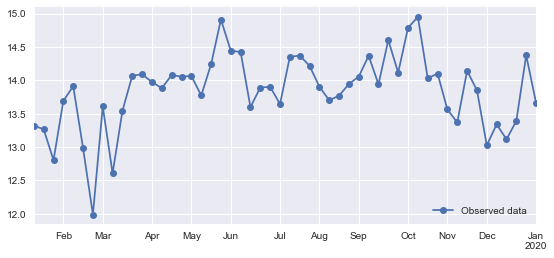

In [159]:
fig, ax = plt.subplots(figsize=(9,4))

mov_avg_7.plot(ax=ax, style='-o', label='Observed data')
plt.legend(loc='lower right')

In [160]:
exp_avg_30 = best_df['EMA']

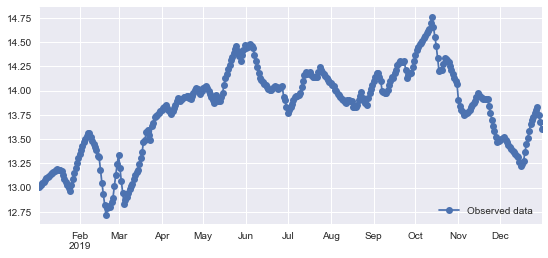

In [161]:
fig, ax = plt.subplots(figsize=(9,4))

exp_avg_30.plot(ax=ax, style='-o', label='Observed data')
plt.legend(loc='lower right')

In [162]:
weekly_exp_avg = exp_avg_30.resample('W').mean()

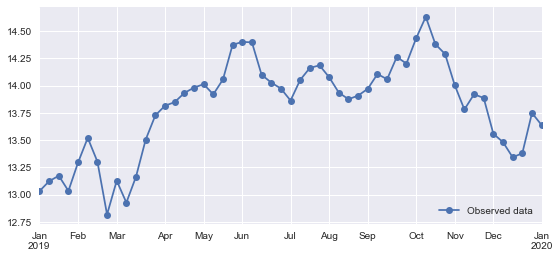

In [163]:
fig, ax = plt.subplots(figsize=(9,4))

weekly_exp_avg.plot(ax=ax, style='-o', label='Observed data')
plt.legend(loc='lower right')

In [164]:
monthly_exp_avg = exp_avg_30.resample('M').mean()

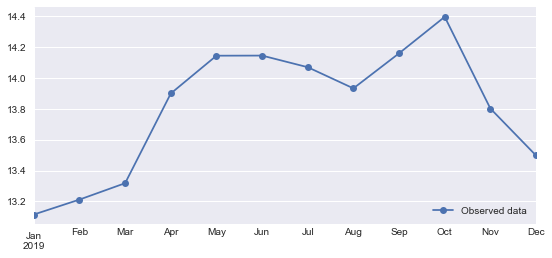

In [165]:
fig, ax = plt.subplots(figsize=(9,4))

monthly_exp_avg.plot(ax=ax, style='-o', label='Observed data')
plt.legend(loc='lower right')

In [166]:
monthly_exp_avg['2019-08']

2019-08-31    13.932524
Freq: M, Name: EMA, dtype: float64

In [167]:
#Let's see if predicting the average weekly pace is a better approximation of the race pace, and if our model can handle it better:

In [168]:
uc_model = sm.tsa.UnobservedComponents(weekly_exp_avg, 'rwalk', autoregressive=1)
res_uc_mle = uc_model.fit()
print(res_uc_mle.summary())

                        Unobserved Components Results                         
Dep. Variable:                    EMA   No. Observations:                   53
Model:                    random walk   Log Likelihood                  13.911
                              + AR(1)   AIC                            -21.823
Date:                Mon, 01 Mar 2021   BIC                            -15.969
Time:                        17:27:26   HQIC                           -19.579
Sample:                    01-06-2019                                         
                         - 01-05-2020                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  1.028e-11      0.065   1.58e-10      1.000      -0.127       0.127
sigma2.ar        0.0338      0.068      0.500 

In [169]:
#Using the same model structure as before:
loglike_uc = Loglike(uc_model)

with pm.Model():
    # Priors
    sigma2level = pm.InverseGamma('sigma2.level', 3, 0.5)
    sigma2ar = pm.InverseGamma('sigma2.ar', 3, 1)
    arL1 = pm.Uniform('ar.L1', -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([sigma2level, sigma2ar, arL1])

    # use a Potential function here in place of DensityDist
    pm.Potential('likelihood', loglike(theta_uc))

    # Draw samples
    trace_uc = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ar.L1, sigma2.ar, sigma2.level]


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `sigma2.ar_log__`.ravel()[0] is zero.

## Adding in Exogenous Variables:

In [ ]:
#We are going to try and add in exogenous variables, such as elevation gain and distance to the model. 